In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import tensorflow as tf
import calfem.geometry as cfg
import calfem.mesh as cfm
import calfem.vis as cfv
from scipy.interpolate import LinearNDInterpolator, CloughTocher2DInterpolator
import sys
import os
import json

In [412]:
nodes_els = nodes[elements]

A11 = np.array([[1,0],[0,1]])
A12 = np.array([[0,0],[0,0]])
A22 = np.array([[1,0.5],[0.5,1]])
A = np.concatenate([
    np.concatenate([A11,A12],axis=1),
    np.concatenate([A12,A22],axis=1)
],axis=0)

r = int(A.shape[-1]/2)
a = None
# a = np.roll(nodes_els[:,:,0],1,axis=1)*np.roll(nodes_els[:,:,1],2,axis=1) - np.roll(nodes_els[:,:,0],2,axis=1)*np.roll(nodes_els[:,:,1],1,axis=1)
b = (np.roll(nodes_els[:,:,1],1,axis=1) - np.roll(nodes_els[:,:,1],2,axis=1)).reshape(-1,3,1)
c = (np.roll(nodes_els[:,:,0],2,axis=1) - np.roll(nodes_els[:,:,0],1,axis=1)).reshape(-1,3,1)
Area = np.abs(np.matmul(nodes_els[:,:,0].reshape(-1,1,3),b))/2
B = np.concatenate([
    np.concatenate([b[:,i:i+1]*np.eye(r).reshape(1,r,r) for i in range(3)],-1),
    np.concatenate([c[:,i:i+1]*np.eye(r).reshape(1,r,r) for i in range(3)],-1)
],-2)/(2*Area)
B_T = np.transpose(B,(0,2,1))
K_els = np.matmul(np.matmul(B_T,A),B)*Area

In [4]:
def PlotMesh(nodes, boundaryNodes, elements):
    plt.figure(figsize=(10,10))
    plt.scatter(nodes[:,0],nodes[:,1])
    if elements.shape[1] == 4:
        for el in elements:
            plt.plot(nodes[[el[0],el[1],el[3],el[2],el[0]],0], nodes[[el[0],el[1],el[3],el[2],el[0]],1], 'k')
    elif elements.shape[1] == 3:
        for el in elements:
            plt.plot(nodes[[el[0],el[1],el[2],el[0]],0], nodes[[el[0],el[1],el[2],el[0]],1], 'k')
    plt.plot(nodes[boundaryNodes,0],nodes[boundaryNodes,1],'r')
    plt.gca().set_aspect('equal', adjustable='box')
    # plt.show()

def GetK_el_triang(A,nodes):
    r = int(A.shape[0]/2)
    # a = np.roll(nodes[:,0],1)*np.roll(nodes[:,1],2) - np.roll(nodes[:,0],2)*np.roll(nodes[:,1],1)
    b = np.roll(nodes[:,1],1) - np.roll(nodes[:,1],2)
    c = np.roll(nodes[:,0],2) - np.roll(nodes[:,0],1)
    Area = np.abs(np.dot(nodes[:,0],b))/2
    B = np.concatenate([
        np.concatenate([b[i]*np.eye(r) for i in range(3)],1),
        np.concatenate([c[i]*np.eye(r) for i in range(3)],1)
    ],0)/(2*Area)
    return np.dot(np.dot(B.T,A),B)*Area


def GetK(nodes_els, A):
    r = int(A.shape[0]/2)
    b = (np.roll(nodes_els[:,:,1],1,axis=1) - np.roll(nodes_els[:,:,1],2,axis=1)).reshape(-1,3,1)
    c = (np.roll(nodes_els[:,:,0],2,axis=1) - np.roll(nodes_els[:,:,0],1,axis=1)).reshape(-1,3,1)
    Area = np.abs(np.matmul(nodes_els[:,:,0].reshape(-1,1,3),b))/2
    B = np.concatenate([
        np.concatenate([b[:,i:i+1]*np.eye(r).reshape(1,r,r) for i in range(3)],-1),
        np.concatenate([c[:,i:i+1]*np.eye(r).reshape(1,r,r) for i in range(3)],-1)
    ],-2)/(2*Area)
    B_T = np.transpose(B,(0,2,1))
    return np.matmul(np.matmul(B_T,A),B)*Area

def SolveFEM(nodes, elements, boundaryNodes, BCfunc, alpha, internalNodes, r, A, A_nl=False, l=None):
    if l is None:
        l = np.zeros((nodes.shape[0], r))
    if not A_nl:
        A_l = A

    # Assemble the global stiffness matrix
    K = np.zeros((nodes.shape[0]*r, nodes.shape[0]*r))
    for el in elements:
        el_idx = [[r*k+j for j in range(r)] for k in el]
        el_idx = np.concatenate(el_idx)
        nodes_el = tf.gather(nodes, indices=el)
        X_idx,Y_idx = np.meshgrid(el_idx,el_idx)
        if A_nl:
            A_l = A(l[el_idx])
        # print(A_l)
        K_el = GetK_el_triang(A_l,nodes_el)
        K[Y_idx,X_idx] += K_el

    # Apply Dirichlet BC
    l_BC = BCfunc(alpha*2*np.pi)
    bc_idx = [[r*i+j for j in range(r)] for i in boundaryNodes]
    bc_idx = np.concatenate(bc_idx)
    internal_idx = [[r*i+j for j in range(r)] for i in internalNodes]
    internal_idx = np.concatenate(internal_idx)

    f = - (K[:,bc_idx] @ l_BC.flatten().reshape(-1,1))

    K_BC = K[internal_idx,:][:,internal_idx]
    f = f[internal_idx]

    # Solve the system
    l_internal = np.linalg.solve(K_BC, f)
    n_CDOF = int(l_internal.shape[0]/r)
    l_internal = l_internal.reshape(n_CDOF, r)

    l[internalNodes,:] = l_internal
    l[boundaryNodes,:] = l_BC.reshape(-1,r)
    return l

def SolveFEM_itt(nodes, elements, boundaryNodes, BCfunc, alpha, internalNodes, r, A, tol=1e-8,show_err=False, max_iter=10):

    l_prev = SolveFEM(nodes, elements, boundaryNodes, BCfunc, alpha, internalNodes, r, A, A_nl=True, l=None)

    err = 1
    i = 1
    while err>tol and i<max_iter:
        l = SolveFEM(nodes, elements, boundaryNodes, BCfunc, alpha, internalNodes, r, A, A_nl=True, l=l_prev.copy())
        err = ((l-l_prev)**2).mean()
        if show_err:
            print(f'Iteration {i}; err = {err}')
        i+=1
        l_prev = l.copy()

    return l, i

def PlotFEMsolution(nodes, elements,l):
    if elements.shape[1] == 4:
        # Convert quadrlateral mesh to triangular mesh
        elements = np.concatenate([elements[:,:3],elements[:,1:]],0)

    # Create a Triangulation object
    triangulation = tri.Triangulation(nodes[:, 0], nodes[:, 1], elements)

    # Plotting
    r = l.shape[1]
    plt.figure(figsize=(6*r,5))
    for i in range(r):
        plt.subplot(1,r,i+1)
        plt.tricontourf(triangulation, l[:,i],10)
        plt.colorbar()
        # plt.scatter(nodes[:,0],nodes[:,1],s=1,c='k')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.gca().set_aspect('equal', adjustable='box')
    return 

def PlotFEMsoluttionDict(solution):
    nodes = np.array(solution['nodes'])
    elements = np.array(solution['elements'])
    l = np.array(solution['l'])
    PlotFEMsolution(nodes, elements,l)

In [8]:
def GenerateGeometry(p):
    g = cfg.Geometry()
    for i in range(p.shape[0]):
        g.point(list(p[i]))
    g.spline(list(range(p.shape[0]))+[0])
    g.surface([0])
    return g

def MeshSurface(g,elSize):
    mesh = cfm.GmshMesh(g)
    mesh.elType = 2       # Degrees of freedom per node.
    mesh.dofsPerNode = 1     # Factor that changes element sizes.
    mesh.elSizeFactor = elSize # Element size Factor
    nodes, edof, dofs, bdofs, elementmarkers = mesh.create()

    elements = edof-1
    boundaryNodes = np.array(bdofs[0])-1
    internalNodes = np.setdiff1d(np.arange(nodes.shape[0]), boundaryNodes)

    alpha = GetDistAlongBoundary(nodes,boundaryNodes)
    return nodes, elements, boundaryNodes, internalNodes, alpha

def GetRandomBCfuncAlpha(n_order=3, r=1):
    p = np.random.randn(2,n_order,r)
    BCfunc_unscaled = lambda alpha: np.array([[p[0,j,i]*np.cos((j+1)*alpha) + p[1,j,i]*np.sin((j+1)*alpha) for i in range(r)] for j in range(n_order)]).T.sum(axis=-1)
    alpha = np.linspace(0,2*np.pi,100)
    vals = BCfunc_unscaled(alpha)
    vals_max = np.max(vals)
    vals_min = np.min(vals)
    BCfunc = lambda alpha: (BCfunc_unscaled(alpha)-vals_min)/(vals_max-vals_min)*2-1
    return BCfunc

def SortBoundaryNodes(boundaryNodes,nodes):
    boundaryNodesSorted = [boundaryNodes[0]]
    boundaryNodesNotSorted = np.delete(boundaryNodes,0)
    for i in range(1,len(boundaryNodes)):
        idx = ((nodes[boundaryNodes[i]]-nodes[boundaryNodesNotSorted])**2).sum(axis=1).argmin()
        boundaryNodesSorted.append(boundaryNodesNotSorted[idx])
        boundaryNodesNotSorted = np.delete(boundaryNodesNotSorted,idx)
    return np.array(boundaryNodesSorted)

def GetDistAlongBoundary(nodes,boundaryNodes):
    ds = [0]+[np.sqrt(((nodes[boundaryNodes[i-1]]-nodes[boundaryNodes[i]])**2).sum()) for i in range(boundaryNodes.shape[0])]
    s = np.cumsum(ds)
    s = s[:-1]/s[-1]
    return s

def GetRandomFixedPoints(n_min = 4,n_max = 10):
    n_points = np.random.randint(n_min,n_max)
    i = 0
    while True:
        angles = np.random.lognormal(0,1,n_points)
        angles = angles/np.sum(angles)*2*np.pi
        i += 1
        if np.all(angles<np.pi) and np.all(angles>np.pi/6):
            break
    # print(i)
    angles = np.cumsum(angles)-angles[0]
    # r = np.abs(np.random.randn(n_points)+1)+0.5
    # r[r>3] = 3
    r = np.random.uniform(0.5,1.5,n_points)
    points = np.zeros((n_points,2))
    for i in range(angles.shape[0]):
        points[i,:] = r[i]*np.array([np.cos(angles[i]),np.sin(angles[i])])
    return points

def GenerateRandomSolution(n_min = 4, n_max = 10, elSize = 0.07, n_order = 3):
    points = GetRandomFixedPoints(n_min,n_max)
    g = GenerateGeometry(points)
    nodes, elements, boundaryNodes, internalNodes, alpha = MeshSurface(g,elSize)
    boundaryNodes = SortBoundaryNodes(boundaryNodes,nodes)
    A = lambda u: np.concatenate([
    np.concatenate([[[10*np.max([u.mean(),0])**2+0.5]],[[0]]],axis=1),
    np.concatenate([[[0]],[[10*np.max([u.mean(),0])**2+0.5]]],axis=1)
    ],axis=0)
    r = 1
    BCfunc = GetRandomBCfuncAlpha(n_order,r=r)
    l,_ = SolveFEM_itt(nodes, elements, boundaryNodes, BCfunc, alpha, internalNodes, r, A, tol=1e-8,show_err=True, max_iter=20)
    mesh = {'nodes':nodes,'elements':elements,'boundaryNodes':boundaryNodes,'internalNodes':internalNodes,'points':points, 'alpha':alpha}
    return l, mesh
    

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpkzvu_2_k/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpkzvu_2_k/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0117881s, CPU 0.011556s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0305022s, CPU 0.029927s)
Info    : 1637 nodes 3268 elements
Info    : Writing '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpkzvu_2_k/meshFile.msh'...
Info    : Done writing '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpkzvu_2_k/meshFile.msh'


Iteration 1; err = 0.03136808155868854
Iteration 2; err = 0.009944437072329296
Iteration 3; err = 0.0016673397858839763
Iteration 4; err = 0.0003509779547026177
Iteration 5; err = 4.3662908587785165e-05
Iteration 6; err = 1.3720484779518451e-05
Iteration 7; err = 2.0021761978982137e-06
Iteration 8; err = 5.418049696849733e-07
Iteration 9; err = 9.394520710959707e-08
Iteration 10; err = 1.9592447750784588e-08
Iteration 11; err = 4.428763846637758e-09


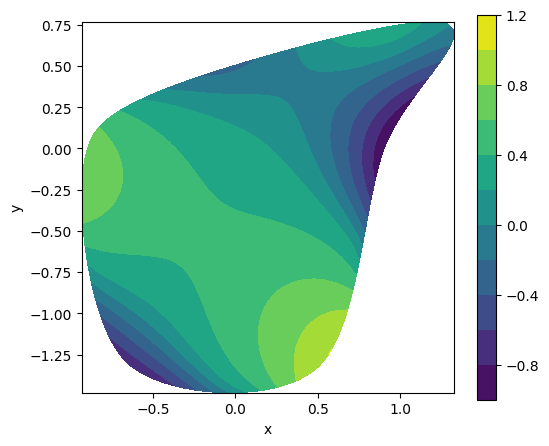

In [9]:
# np.random.seed(1)
l, mesh =  GenerateRandomSolution(n_min = 4, n_max = 8, elSize = 0.05, n_order = 3)

PlotFEMsolution(mesh['nodes'], mesh['elements'],l)
# plt.scatter(nodes[:,0],nodes[:,1],c='k',s=1)
nodes = mesh['nodes']
boundaryNodes = mesh['boundaryNodes']
points = mesh['points']
elements = mesh['elements']
alpha = mesh['alpha']

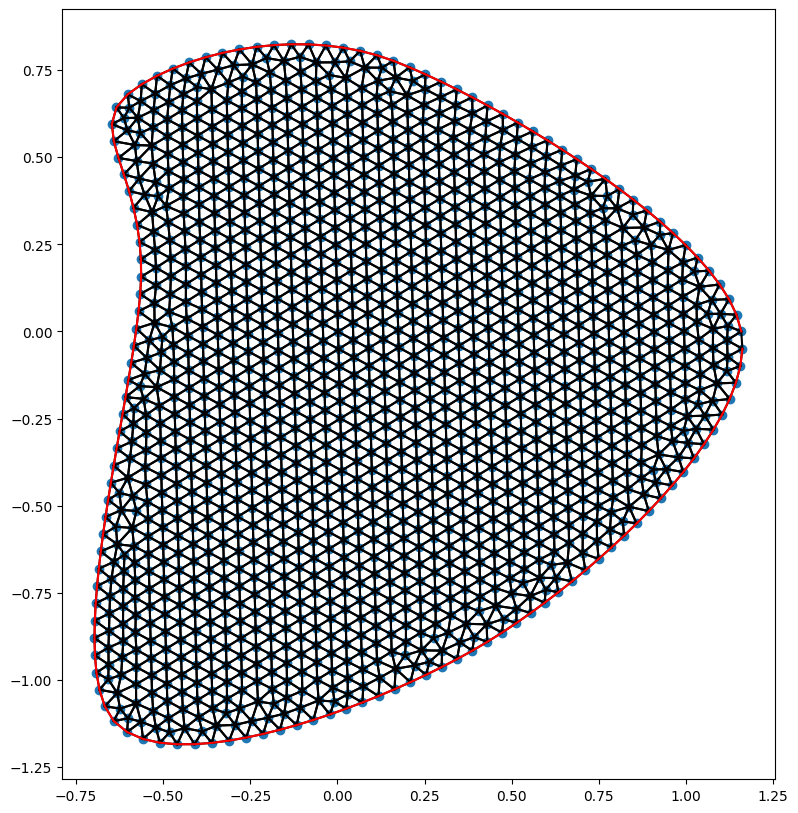

In [53]:
PlotMesh(nodes, boundaryNodes, elements)

In [438]:
def ConvertDictNP2List(d):
    for key in d.keys():
        d[key] = d[key].tolist()
    return d

# Create the dataset
n_solutions = 100
dataset = []
for i in range(n_solutions):
    print(f'\n {i+1}/{n_solutions} \n')
    l, mesh =  GenerateRandomSolution(n_min = 4, n_max = 8, elSize = 0.05, n_order = 3)
    mesh['l'] = l
    dataset.append(ConvertDictNP2List(mesh))


 1/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpolld4vtv/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpolld4vtv/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00858396s, CPU 0.008319s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0236545s, CPU 0.023184s)
Info    : 1213 nodes 2422 elements
Info    : Writing '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpolld4vtv/meshFile.msh'...
Info    : Done writing '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpolld4vtv/meshFile.msh'


Iteration 1; err = 0.016741059155213425
Iteration 2; err = 0.005617360442193087
Iteration 3; err = 0.0015028340439401625
Iteration 4; err = 0.00023085978303473152
Iteration 5; err = 2.6335378088040135e-05
Iteration 6; err = 9.725939414248918e-06
Iteration 7; err = 9.898083349089021e-07
Iteration 8; err = 4.0112236883536316e-07
Iteration 9; err = 4.34078755479972e-08
Iteration 10; err = 1.3546532130209602e-08
Iteration 11; err = 2.149272704639805e-09

 2/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp0794xr3j/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp0794xr3j/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0113899s, CPU 0.022264s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.023926s, CPU 0.045119s)
Info    : 1401 nodes 2798 elements
Info    : Wri

Iteration 1; err = 0.0360031518101215
Iteration 2; err = 0.009597246041014305
Iteration 3; err = 0.0022982330033056537
Iteration 4; err = 0.0004985509444339879
Iteration 5; err = 6.449843952408274e-05
Iteration 6; err = 1.2668740759296504e-05
Iteration 7; err = 3.6750757772885535e-06
Iteration 8; err = 4.6118541917500396e-07
Iteration 9; err = 1.748259819426638e-07
Iteration 10; err = 2.3135434125124257e-08
Iteration 11; err = 6.245108619786609e-09

 3/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp4eneanlr/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp4eneanlr/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0124939s, CPU 0.023127s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0340083s, CPU 0.108553s)
Info    : 1682 nodes 3358 elements
Info    : Wri

Iteration 1; err = 0.029634645370634476
Iteration 2; err = 0.013743981364999646
Iteration 3; err = 0.003274354163139973
Iteration 4; err = 0.0007121262740707932
Iteration 5; err = 0.0001580460980438968
Iteration 6; err = 4.4956328898776786e-05
Iteration 7; err = 1.1260834927890288e-05
Iteration 8; err = 3.044014997394439e-06
Iteration 9; err = 7.45976170780576e-07
Iteration 10; err = 1.9817444394974385e-07
Iteration 11; err = 4.97037324737087e-08
Iteration 12; err = 1.2915629418107964e-08
Iteration 13; err = 3.3062588202720827e-09

 4/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpxzw6edp0/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpxzw6edp0/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.012052s, CPU 0.022171s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2

Iteration 1; err = 0.0426312029513313
Iteration 2; err = 0.009023531497815923
Iteration 3; err = 0.002077134786076689
Iteration 4; err = 0.00038623326563437787
Iteration 5; err = 5.941482698568816e-05
Iteration 6; err = 1.678305208215211e-05
Iteration 7; err = 2.7969466660341265e-06
Iteration 8; err = 7.466916573765187e-07
Iteration 9; err = 1.3269182666994894e-07
Iteration 10; err = 3.0814606287108556e-08
Iteration 11; err = 6.325397282358662e-09

 5/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpt52gq_m_/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpt52gq_m_/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0168378s, CPU 0.031103s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0238929s, CPU 0.048458s)
Info    : 1367 nodes 2727 elements
Info    : Writ

Iteration 1; err = 0.03283955455392052
Iteration 2; err = 0.017176062314784243
Iteration 3; err = 0.00645093626893587
Iteration 4; err = 0.0015643607594190481
Iteration 5; err = 0.00028649017556423874
Iteration 6; err = 8.323122068372725e-05
Iteration 7; err = 2.4871384744549225e-05
Iteration 8; err = 5.686566475492208e-06
Iteration 9; err = 2.2308751013849323e-06
Iteration 10; err = 4.0156054848366935e-07
Iteration 11; err = 1.6541166833298566e-07
Iteration 12; err = 3.7254142064641084e-08
Iteration 13; err = 1.0570134096759157e-08
Iteration 14; err = 3.5904109233729453e-09

 6/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpjc99rd_e/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpjc99rd_e/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0126412s, CPU 0.024281s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Pla

Iteration 1; err = 0.031969427326592664
Iteration 2; err = 0.008541850023588912
Iteration 3; err = 0.0017432562626076705
Iteration 4; err = 0.00034759846674687267
Iteration 5; err = 3.102120060849524e-05
Iteration 6; err = 1.2530412850034269e-05
Iteration 7; err = 1.248040992234993e-06
Iteration 8; err = 4.7184094829768747e-07
Iteration 9; err = 5.7134801271307255e-08
Iteration 10; err = 1.5175329743604273e-08
Iteration 11; err = 2.720333114991209e-09

 7/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpqpfiwtpc/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpqpfiwtpc/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00678546s, CPU 0.014053s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.016259s, CPU 0.033336s)
Info    : 1132 nodes 2259 elements
Info    : 

Iteration 1; err = 0.017173947970791012
Iteration 2; err = 0.0073069633926642315
Iteration 3; err = 0.002028440054791811
Iteration 4; err = 0.0003227575056700611
Iteration 5; err = 6.629347855469516e-05
Iteration 6; err = 1.5898133403546672e-05
Iteration 7; err = 3.2126220057786804e-06
Iteration 8; err = 8.894042804714565e-07
Iteration 9; err = 1.5417855204094442e-07
Iteration 10; err = 4.4884962716536685e-08
Iteration 11; err = 7.793915813118497e-09

 8/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpmew6yqfw/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpmew6yqfw/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.008268s, CPU 0.016672s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0119593s, CPU 0.024589s)
Info    : 828 nodes 1649 elements
Info    : Wri

Iteration 1; err = 0.01643684841025196
Iteration 2; err = 0.006944563354686511
Iteration 3; err = 0.0015094575342232666
Iteration 4; err = 0.00019211417813799406
Iteration 5; err = 3.535510438797577e-05
Iteration 6; err = 6.5933050122309995e-06
Iteration 7; err = 1.1801312758881875e-06
Iteration 8; err = 2.3283608925442354e-07
Iteration 9; err = 3.9071680308021504e-08
Iteration 10; err = 7.968593395655663e-09

 9/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpsassbl28/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpsassbl28/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00719504s, CPU 0.01462s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0298526s, CPU 0.060553s)
Info    : 2019 nodes 4032 elements
Info    : Writing '/var/folders/d7/0s3_ltgs6476j7ypg4

Iteration 1; err = 0.013098283720919118
Iteration 2; err = 0.004978115093564778
Iteration 3; err = 0.0012686911203316912
Iteration 4; err = 0.00016287656081348726
Iteration 5; err = 3.240093305119544e-05
Iteration 6; err = 7.969872601579934e-06
Iteration 7; err = 1.2820387975492917e-06
Iteration 8; err = 3.7749596820213655e-07
Iteration 9; err = 4.634986807769832e-08
Iteration 10; err = 1.6337107831253075e-08
Iteration 11; err = 1.8357717808055019e-09

 10/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp_g9kon1w/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp_g9kon1w/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.012414s, CPU 0.02466s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0245694s, CPU 0.047076s)
Info    : 796 nodes 1587 elements
Info    : Wr

Iteration 1; err = 0.02153975823936746
Iteration 2; err = 0.00550060865212682
Iteration 3; err = 0.0015336163022427328
Iteration 4; err = 0.0002852154076491222
Iteration 5; err = 3.2189397962121996e-05
Iteration 6; err = 1.0536560701257299e-05
Iteration 7; err = 1.6887294978793618e-06
Iteration 8; err = 3.7821538413114155e-07
Iteration 9; err = 9.684781832000556e-08
Iteration 10; err = 1.2085356987889939e-08
Iteration 11; err = 4.588172992347689e-09

 11/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp6hpmukqh/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp6hpmukqh/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0143424s, CPU 0.026277s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0364928s, CPU 0.074462s)
Info    : 1771 nodes 3535 elements
Info    : W

Iteration 1; err = 0.02322984739240827
Iteration 2; err = 0.009337936061521957
Iteration 3; err = 0.00175718214975748
Iteration 4; err = 0.00038429808484904737
Iteration 5; err = 6.992257612615369e-05
Iteration 6; err = 1.9080944656004005e-05
Iteration 7; err = 3.816966416899584e-06
Iteration 8; err = 9.729244568305802e-07
Iteration 9; err = 1.9459499537093152e-07
Iteration 10; err = 4.8642328401369836e-08
Iteration 11; err = 1.0056438801579546e-08
Iteration 12; err = 2.4186522386914397e-09

 12/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpwgk8xzs0/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpwgk8xzs0/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00883317s, CPU 0.022446s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0285803s, CPU 0.057441s)
Inf

Iteration 1; err = 0.015780100315297356
Iteration 2; err = 0.007081719221291839
Iteration 3; err = 0.0017341057913276986
Iteration 4; err = 0.0002698629675095082
Iteration 5; err = 7.478415374217132e-05
Iteration 6; err = 1.445229630501326e-05
Iteration 7; err = 4.228071858906937e-06
Iteration 8; err = 8.122449536902218e-07
Iteration 9; err = 2.190161109114363e-07
Iteration 10; err = 4.560069380074835e-08
Iteration 11; err = 1.1212201639401228e-08
Iteration 12; err = 2.5716326503739925e-09

 13/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpodehg5eq/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpodehg5eq/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00965792s, CPU 0.065478s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0295205s, CPU 0.058887s)
Info

Iteration 1; err = 0.027140419452250743
Iteration 2; err = 0.013653701024629233
Iteration 3; err = 0.0032198731989038923
Iteration 4; err = 0.0007050314873240158
Iteration 5; err = 0.00018320451887340362
Iteration 6; err = 4.533314548585758e-05
Iteration 7; err = 1.359612283333336e-05
Iteration 8; err = 3.0613097060764774e-06
Iteration 9; err = 9.42004714763314e-07
Iteration 10; err = 2.0509222190941491e-07
Iteration 11; err = 6.439352161032927e-08
Iteration 12; err = 1.4014171175425502e-08
Iteration 13; err = 4.3276002212387455e-09

 14/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpbf033hk0/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpbf033hk0/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0181146s, CPU 0.030206s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshi

Iteration 1; err = 0.03752961515791247
Iteration 2; err = 0.009081308251778218
Iteration 3; err = 0.0018292960503418227
Iteration 4; err = 0.00033678573313703495
Iteration 5; err = 5.037301130171715e-05
Iteration 6; err = 1.3950565842821527e-05
Iteration 7; err = 2.1372031559646987e-06
Iteration 8; err = 5.913719048520464e-07
Iteration 9; err = 8.933848724116248e-08
Iteration 10; err = 2.384750067017908e-08
Iteration 11; err = 3.850071405346086e-09

 15/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpumws3wbd/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpumws3wbd/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0150016s, CPU 0.029263s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0460617s, CPU 0.087558s)
Info    : 1058 nodes 2112 elements
Info    : Wr

Iteration 1; err = 0.030362592930158055
Iteration 2; err = 0.0056630364762842314
Iteration 3; err = 0.0013128638944116754
Iteration 4; err = 0.0002698719833234011
Iteration 5; err = 2.829069360604876e-05
Iteration 6; err = 5.940737695537249e-06
Iteration 7; err = 1.390398454246736e-06
Iteration 8; err = 1.582364338814651e-07
Iteration 9; err = 5.761411015817125e-08
Iteration 10; err = 6.0155644296235314e-09

 16/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpkmc8jv4t/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpkmc8jv4t/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0120461s, CPU 0.025481s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0335751s, CPU 0.071211s)
Info    : 1754 nodes 3503 elements
Info    : Writing '/var/folders/d7/0s3_ltgs6476j7ypg4t

Iteration 1; err = 0.024595134600703547
Iteration 2; err = 0.005733975139469158
Iteration 3; err = 0.0011937973868925615
Iteration 4; err = 0.00023032428935639896
Iteration 5; err = 4.090739492811964e-05
Iteration 6; err = 1.1490228042742249e-05
Iteration 7; err = 2.08371814115753e-06
Iteration 8; err = 5.815721071562406e-07
Iteration 9; err = 9.828580641214902e-08
Iteration 10; err = 2.8752956221253197e-08
Iteration 11; err = 4.7530237749004084e-09

 17/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmps769j6ju/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmps769j6ju/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0070905s, CPU 0.015382s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0377212s, CPU 0.079549s)
Info    : 1733 nodes 3461 elements
Info    : W

Iteration 1; err = 0.03304754956784317
Iteration 2; err = 0.017752792479251513
Iteration 3; err = 0.004189124063506076
Iteration 4; err = 0.0008265509987904152
Iteration 5; err = 0.00017677854752599025
Iteration 6; err = 4.267596770947696e-05
Iteration 7; err = 1.1316138446808562e-05
Iteration 8; err = 2.7388926691813884e-06
Iteration 9; err = 7.051989483213206e-07
Iteration 10; err = 1.6836866846115952e-07
Iteration 11; err = 4.362877751314883e-08
Iteration 12; err = 1.0612408164413686e-08
Iteration 13; err = 2.695776673874057e-09

 18/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp_ixthm97/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp_ixthm97/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0121434s, CPU 0.024779s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshin

Iteration 1; err = 0.020227306652054564
Iteration 2; err = 0.003670700905224054
Iteration 3; err = 0.0009565440606785036
Iteration 4; err = 0.00018975750028955117
Iteration 5; err = 2.1558060460573765e-05
Iteration 6; err = 7.0829667928002865e-06
Iteration 7; err = 1.1710776827708818e-06
Iteration 8; err = 2.707770316334572e-07
Iteration 9; err = 6.941978180985358e-08
Iteration 10; err = 9.08189908233029e-09

 19/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpoct0y7a9/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpoct0y7a9/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0111003s, CPU 0.023334s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0303629s, CPU 0.064956s)
Info    : 1746 nodes 3488 elements
Info    : Writing '/var/folders/d7/0s3_ltgs6476j7ypg4

Iteration 1; err = 0.030247375791527593
Iteration 2; err = 0.008825414369477144
Iteration 3; err = 0.001972451059529893
Iteration 4; err = 0.0003471664705794914
Iteration 5; err = 5.3348087077827565e-05
Iteration 6; err = 1.581208220465572e-05
Iteration 7; err = 2.389959614089537e-06
Iteration 8; err = 7.343330382420412e-07
Iteration 9; err = 1.1220364959832698e-07
Iteration 10; err = 3.066687381224416e-08
Iteration 11; err = 5.638154724795635e-09

 20/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpym42_l8b/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpym42_l8b/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00636267s, CPU 0.013793s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0362899s, CPU 0.073551s)
Info    : 1838 nodes 3670 elements
Info    : Wr

Iteration 1; err = 0.01840975496947777
Iteration 2; err = 0.003138615888145816
Iteration 3; err = 0.0006061121439733172
Iteration 4; err = 6.572297035690834e-05
Iteration 5; err = 7.610971598394387e-06
Iteration 6; err = 1.5450558934014343e-06
Iteration 7; err = 1.362044359535531e-07
Iteration 8; err = 3.048022120745537e-08
Iteration 9; err = 2.7028304377503324e-09

 21/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp1xrhw67v/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp1xrhw67v/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00671604s, CPU 0.014417s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0370365s, CPU 0.137078s)
Info    : 1884 nodes 3763 elements
Info    : Writing '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp1xrhw67v/meshFile.msh'...

Iteration 1; err = 0.03430687570637858
Iteration 2; err = 0.012202296952385963
Iteration 3; err = 0.0021332401679943764
Iteration 4; err = 0.000529237650124953
Iteration 5; err = 7.237203537289667e-05
Iteration 6; err = 2.1092960513181752e-05
Iteration 7; err = 4.341944860639637e-06
Iteration 8; err = 9.448106594976752e-07
Iteration 9; err = 2.5525338384203397e-07
Iteration 10; err = 4.065216943774535e-08
Iteration 11; err = 1.3969275837272943e-08
Iteration 12; err = 1.991065072088305e-09

 22/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpxt2c_frx/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpxt2c_frx/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00655796s, CPU 0.013676s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0333128s, CPU 0.086514s)
Info 

Iteration 1; err = 0.031037888126281624
Iteration 2; err = 0.015191056399243327
Iteration 3; err = 0.002570349893342308
Iteration 4; err = 0.0006227796052369196
Iteration 5; err = 9.040145379455086e-05
Iteration 6; err = 2.21587395096987e-05
Iteration 7; err = 4.7153609024617435e-06
Iteration 8; err = 9.216292107803134e-07
Iteration 9; err = 2.443135260226021e-07
Iteration 10; err = 3.742499751604285e-08
Iteration 11; err = 1.1920848072886048e-08
Iteration 12; err = 1.7009605057588712e-09

 23/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpj9b_vopt/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpj9b_vopt/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0159039s, CPU 0.051916s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0254204s, CPU 0.171239s)
Info  

Iteration 1; err = 0.029776706008083905
Iteration 2; err = 0.010389289098292214
Iteration 3; err = 0.002908420569267269
Iteration 4; err = 0.0007164229755179982
Iteration 5; err = 0.00011226172083241179
Iteration 6; err = 2.6732684122102288e-05
Iteration 7; err = 8.341368083378087e-06
Iteration 8; err = 1.4877252494885296e-06
Iteration 9; err = 5.958492109988464e-07
Iteration 10; err = 9.27757683847734e-08
Iteration 11; err = 3.460802765892541e-08
Iteration 12; err = 7.562432619066413e-09

 24/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpckf1k3yg/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpckf1k3yg/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0109485s, CPU 0.022003s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0349036s, CPU 0.260346s)
Info  

Iteration 1; err = 0.02833077713663246
Iteration 2; err = 0.007652886621205703
Iteration 3; err = 0.0012143037995087777
Iteration 4; err = 0.0002567170764499843
Iteration 5; err = 2.115903644420513e-05
Iteration 6; err = 6.619143326002635e-06
Iteration 7; err = 7.311856192228576e-07
Iteration 8; err = 1.8881569438118382e-07
Iteration 9; err = 2.7193560597806854e-08
Iteration 10; err = 4.842348998853979e-09

 25/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpo5mwf_i9/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpo5mwf_i9/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00628554s, CPU 0.01385s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.015676s, CPU 0.042469s)
Info    : 834 nodes 1663 elements
Info    : Writing '/var/folders/d7/0s3_ltgs6476j7ypg4tch4

Iteration 1; err = 0.024798895488802295
Iteration 2; err = 0.011639254893145679
Iteration 3; err = 0.0026168592238504603
Iteration 4; err = 0.0006573497080431832
Iteration 5; err = 0.00011792721122628962
Iteration 6; err = 2.2471706718775364e-05
Iteration 7; err = 6.279174538156053e-06
Iteration 8; err = 9.776786895704054e-07
Iteration 9; err = 3.1970431995157786e-07
Iteration 10; err = 4.56369121798634e-08
Iteration 11; err = 1.4172682769228983e-08
Iteration 12; err = 2.477316592892276e-09

 26/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp2cfruhx3/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp2cfruhx3/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0113905s, CPU 0.024246s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0159876s, CPU 0.034599s)
Info

Iteration 1; err = 0.025728266909292072
Iteration 2; err = 0.008110363185842453
Iteration 3; err = 0.0020047808767284627
Iteration 4; err = 0.0005145341642875767
Iteration 5; err = 6.825391484215518e-05
Iteration 6; err = 1.7833148662490087e-05
Iteration 7; err = 4.650283525170192e-06
Iteration 8; err = 8.297121034308466e-07
Iteration 9; err = 3.150572408042652e-07
Iteration 10; err = 4.147073289921797e-08
Iteration 11; err = 1.7275611493181218e-08
Iteration 12; err = 2.9449130129767727e-09

 27/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpe3gelya5/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpe3gelya5/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0126049s, CPU 0.025633s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0304651s, CPU 0.063977s)
Info

Iteration 1; err = 0.014364263244222904
Iteration 2; err = 0.0070273774872222396
Iteration 3; err = 0.002035436768616012
Iteration 4; err = 0.00019832896225314848
Iteration 5; err = 2.758413557871733e-05
Iteration 6; err = 7.5570028183209015e-06
Iteration 7; err = 6.920085636067178e-07
Iteration 8; err = 2.5761857141058186e-07
Iteration 9; err = 2.2915254139469684e-08
Iteration 10; err = 7.302086922589925e-09

 28/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp4fleyut0/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp4fleyut0/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0119443s, CPU 0.025238s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0246597s, CPU 0.05273s)
Info    : 1300 nodes 2594 elements
Info    : Writing '/var/folders/d7/0s3_ltgs6476j7ypg4

Iteration 1; err = 0.029826527124482034
Iteration 2; err = 0.005994253902472372
Iteration 3; err = 0.0012039711659126828
Iteration 4; err = 0.00029107555014405543
Iteration 5; err = 4.4612486441061814e-05
Iteration 6; err = 1.539038317139706e-05
Iteration 7; err = 2.3325969052646597e-06
Iteration 8; err = 8.276838695798789e-07
Iteration 9; err = 1.1810302430849231e-07
Iteration 10; err = 4.418676656276173e-08
Iteration 11; err = 6.183456431373127e-09

 29/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmphwc850nt/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmphwc850nt/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00650763s, CPU 0.013804s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0124564s, CPU 0.026724s)
Info    : 846 nodes 1687 elements
Info    : 

Iteration 1; err = 0.02764857876451834
Iteration 2; err = 0.009632312060596112
Iteration 3; err = 0.0013336547978576908
Iteration 4; err = 0.0003528886815936196
Iteration 5; err = 3.7027357817858456e-05
Iteration 6; err = 1.1829159715617493e-05
Iteration 7; err = 1.5651202297165618e-06
Iteration 8; err = 4.2504981516144567e-07
Iteration 9; err = 6.652472449637989e-08
Iteration 10; err = 1.4982119033153577e-08
Iteration 11; err = 2.8837266681844136e-09

 30/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmptlzk59i6/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmptlzk59i6/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0108255s, CPU 0.021906s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0212254s, CPU 0.045555s)
Info    : 1031 nodes 2058 elements
Info    :

Iteration 1; err = 0.031788315638462676
Iteration 2; err = 0.012396878168871892
Iteration 3; err = 0.002488312142117442
Iteration 4; err = 0.0005214849701069509
Iteration 5; err = 5.1975323338664426e-05
Iteration 6; err = 1.789370308287628e-05
Iteration 7; err = 2.2703215849112317e-06
Iteration 8; err = 6.865816860812681e-07
Iteration 9; err = 1.056435817297755e-07
Iteration 10; err = 2.2525108533733595e-08
Iteration 11; err = 4.885710279025622e-09

 31/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp8lo4szrc/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp8lo4szrc/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0148272s, CPU 0.029154s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0295404s, CPU 0.062744s)
Info    : 1534 nodes 3061 elements
Info    : Wr

Iteration 1; err = 0.0252869997046257
Iteration 2; err = 0.014794730139591745
Iteration 3; err = 0.00579453285211384
Iteration 4; err = 0.0012647089231115163
Iteration 5; err = 0.0002347168990106155
Iteration 6; err = 9.336806284594991e-05
Iteration 7; err = 1.806156607995058e-05
Iteration 8; err = 7.580622923404959e-06
Iteration 9; err = 1.6130816904544503e-06
Iteration 10; err = 4.947630991694028e-07
Iteration 11; err = 1.4899276769161422e-07
Iteration 12; err = 3.159341039660276e-08
Iteration 13; err = 1.2804861918851408e-08
Iteration 14; err = 2.2034803831305365e-09

 32/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp5iz7ml4u/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp5iz7ml4u/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0107911s, CPU 0.023037s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, 

Iteration 1; err = 0.04420447191694302
Iteration 2; err = 0.012888097572891973
Iteration 3; err = 0.003238541230018135
Iteration 4; err = 0.0008618804003033437
Iteration 5; err = 0.00011772047970261042
Iteration 6; err = 3.5236347796621316e-05
Iteration 7; err = 9.092825643388272e-06
Iteration 8; err = 1.7916675874519865e-06
Iteration 9; err = 6.690114690669707e-07
Iteration 10; err = 9.669432533759609e-08
Iteration 11; err = 4.064989708830223e-08
Iteration 12; err = 7.251713223116463e-09

 33/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp4qsf95bv/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp4qsf95bv/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.012121s, CPU 0.089507s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0227943s, CPU 0.047626s)
Info   

Iteration 1; err = 0.029245796633523554
Iteration 2; err = 0.014470147704809462
Iteration 3; err = 0.00515217753334932
Iteration 4; err = 0.0012138701592332183
Iteration 5; err = 0.00021338240661833956
Iteration 6; err = 8.401122463958434e-05
Iteration 7; err = 1.8797088724672703e-05
Iteration 8; err = 7.156205453231955e-06
Iteration 9; err = 1.8535655668770496e-06
Iteration 10; err = 4.769733550626333e-07
Iteration 11; err = 1.7905036652408373e-07
Iteration 12; err = 3.3362735345374816e-08
Iteration 13; err = 1.559519298470266e-08
Iteration 14; err = 2.720882455906012e-09

 34/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmphykry8rz/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmphykry8rz/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00710583s, CPU 0.014881s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Pla

Iteration 1; err = 0.02699164981007597
Iteration 2; err = 0.0069387652507901035
Iteration 3; err = 0.0014441174507717424
Iteration 4; err = 0.00026239377194399194
Iteration 5; err = 3.244542316696382e-05
Iteration 6; err = 9.619040937980262e-06
Iteration 7; err = 1.2649027313051032e-06
Iteration 8; err = 3.7435749477839865e-07
Iteration 9; err = 5.300442802899892e-08
Iteration 10; err = 1.3069216603131716e-08
Iteration 11; err = 2.3444409581628082e-09

 35/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmprs9rzqis/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmprs9rzqis/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00694713s, CPU 0.015532s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0296395s, CPU 0.122413s)
Info    : 1406 nodes 2806 elements
Info    

Iteration 1; err = 0.025530489885097638
Iteration 2; err = 0.006054638941391508
Iteration 3; err = 0.001155162530154209
Iteration 4; err = 0.00023157000573928774
Iteration 5; err = 2.340602646905738e-05
Iteration 6; err = 6.176093088994182e-06
Iteration 7; err = 1.0420610022901136e-06
Iteration 8; err = 1.9340325013553907e-07
Iteration 9; err = 4.77049107145259e-08
Iteration 10; err = 5.8310362866811044e-09

 36/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpvk_6du4a/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpvk_6du4a/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00689246s, CPU 0.020468s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0239002s, CPU 0.084098s)
Info    : 1222 nodes 2439 elements
Info    : Writing '/var/folders/d7/0s3_ltgs6476j7ypg4

Iteration 1; err = 0.013108003676813083
Iteration 2; err = 0.004985996622106133
Iteration 3; err = 0.001295542693133064
Iteration 4; err = 0.00018004261792867952
Iteration 5; err = 2.559693894325789e-05
Iteration 6; err = 7.655108951399474e-06
Iteration 7; err = 8.789510909487131e-07
Iteration 8; err = 3.048458470535912e-07
Iteration 9; err = 3.540652340868706e-08
Iteration 10; err = 1.0087378835327775e-08
Iteration 11; err = 1.6328681852696558e-09

 37/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp5bb6esln/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp5bb6esln/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00776125s, CPU 0.062935s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0247095s, CPU 0.098022s)
Info    : 1639 nodes 3272 elements
Info    : W

Iteration 1; err = 0.014818674783256642
Iteration 2; err = 0.006355793096283786
Iteration 3; err = 0.001915797550660694
Iteration 4; err = 0.0003270012194275227
Iteration 5; err = 4.1259967468745313e-05
Iteration 6; err = 1.4049086440856425e-05
Iteration 7; err = 1.8803221476679522e-06
Iteration 8; err = 6.208661369673288e-07
Iteration 9; err = 1.0494994470806053e-07
Iteration 10; err = 2.1819114980687426e-08
Iteration 11; err = 5.8399675449966e-09

 38/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp0i_wsako/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp0i_wsako/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0167731s, CPU 0.082098s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0419661s, CPU 0.242062s)
Info    : 1531 nodes 3055 elements
Info    : Wr

Iteration 1; err = 0.023348901033688616
Iteration 2; err = 0.007872728804520283
Iteration 3; err = 0.0012123322457069504
Iteration 4; err = 0.0002213631284297865
Iteration 5; err = 3.434297513720171e-05
Iteration 6; err = 7.401160047102307e-06
Iteration 7; err = 1.3570835815609812e-06
Iteration 8; err = 2.6106388110955453e-07
Iteration 9; err = 5.2273605781772426e-08
Iteration 10; err = 9.101771603341379e-09

 39/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmplcacvdf4/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmplcacvdf4/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0162971s, CPU 0.028807s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0168306s, CPU 0.033625s)
Info    : 891 nodes 1778 elements
Info    : Writing '/var/folders/d7/0s3_ltgs6476j7ypg4t

Iteration 1; err = 0.007436934081382769
Iteration 2; err = 0.003336788878542434
Iteration 3; err = 0.001103546548165729
Iteration 4; err = 0.00016749237768404516
Iteration 5; err = 1.413514153694644e-05
Iteration 6; err = 7.419870631465162e-06
Iteration 7; err = 5.237538669437776e-07
Iteration 8; err = 2.7138161640537305e-07
Iteration 9; err = 3.024922558276025e-08
Iteration 10; err = 7.0398450361253355e-09

 40/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpw39ypcmw/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpw39ypcmw/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0114131s, CPU 0.022984s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0270619s, CPU 0.055771s)
Info    : 1312 nodes 2618 elements
Info    : Writing '/var/folders/d7/0s3_ltgs6476j7ypg4t

Iteration 1; err = 0.02373302542552246
Iteration 2; err = 0.0075159750572437916
Iteration 3; err = 0.0013146371195014426
Iteration 4; err = 0.00028862842605518324
Iteration 5; err = 3.21766909212016e-05
Iteration 6; err = 1.0720966976700698e-05
Iteration 7; err = 1.2513369244724041e-06
Iteration 8; err = 4.2174949126814854e-07
Iteration 9; err = 4.7040926010237744e-08
Iteration 10; err = 1.608847382681733e-08
Iteration 11; err = 1.8021549873553203e-09

 41/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpd57ykicr/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpd57ykicr/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00905863s, CPU 0.018226s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0170106s, CPU 0.034934s)
Info    : 886 nodes 1767 elements
Info    :

Iteration 1; err = 0.03236552466702312
Iteration 2; err = 0.014195329921951758
Iteration 3; err = 0.004651690805740003
Iteration 4; err = 0.0011863334599163645
Iteration 5; err = 0.00022676129724077664
Iteration 6; err = 5.698293030979847e-05
Iteration 7; err = 1.8702832530049933e-05
Iteration 8; err = 4.122843511339849e-06
Iteration 9; err = 1.501091605808413e-06
Iteration 10; err = 3.19175683405324e-07
Iteration 11; err = 1.0461557544805214e-07
Iteration 12; err = 2.826610416327118e-08
Iteration 13; err = 6.8790131859903985e-09

 42/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpod_cnqd5/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpod_cnqd5/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00612071s, CPU 0.013293s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing

Iteration 1; err = 0.011810695900029282
Iteration 2; err = 0.0052532591071117775
Iteration 3; err = 0.001568917355574099
Iteration 4; err = 0.00022170037254979952
Iteration 5; err = 3.0168557008578008e-05
Iteration 6; err = 1.0944118588053793e-05
Iteration 7; err = 1.1403146273494324e-06
Iteration 8; err = 5.003071526948637e-07
Iteration 9; err = 5.147346937187223e-08
Iteration 10; err = 1.848414214083388e-08
Iteration 11; err = 2.792855440938645e-09

 43/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpv6v3u2hf/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpv6v3u2hf/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00607642s, CPU 0.012847s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0369761s, CPU 0.07413s)
Info    : 1675 nodes 3346 elements
Info    : 

Iteration 1; err = 0.01796407418278383
Iteration 2; err = 0.01059076421610663
Iteration 3; err = 0.00398448348148772
Iteration 4; err = 0.0007380380037557644
Iteration 5; err = 0.00011003014436769529
Iteration 6; err = 5.122778020354401e-05
Iteration 7; err = 6.7863541383846e-06
Iteration 8; err = 3.4512376960067674e-06
Iteration 9; err = 5.216926066340184e-07
Iteration 10; err = 1.7678815088952583e-07
Iteration 11; err = 4.369280669296283e-08
Iteration 12; err = 8.291371259694426e-09

 44/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpa4p4sd3v/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpa4p4sd3v/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00715887s, CPU 0.015525s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0167785s, CPU 0.035263s)
Info    :

Iteration 1; err = 0.026368323339479496
Iteration 2; err = 0.012403140429727155
Iteration 3; err = 0.004771444172803878
Iteration 4; err = 0.001223884065319283
Iteration 5; err = 0.00015716859003160917
Iteration 6; err = 5.6232031575254347e-05
Iteration 7; err = 1.4433672682611623e-05
Iteration 8; err = 3.7010912623710723e-06
Iteration 9; err = 1.4089342792605072e-06
Iteration 10; err = 1.8868542000684634e-07
Iteration 11; err = 1.1369109895045607e-07
Iteration 12; err = 1.3900865237238645e-08
Iteration 13; err = 7.375423028644847e-09

 45/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpkmcdxkdg/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpkmcdxkdg/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00677746s, CPU 0.014181s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done me

Iteration 1; err = 0.03544854349631919
Iteration 2; err = 0.01825342870848259
Iteration 3; err = 0.0071939302574788744
Iteration 4; err = 0.0018431653398876518
Iteration 5; err = 0.0002859142779931465
Iteration 6; err = 9.58783589510213e-05
Iteration 7; err = 3.11041769754866e-05
Iteration 8; err = 6.1226848837984846e-06
Iteration 9; err = 2.9452007006885846e-06
Iteration 10; err = 4.171602570880676e-07
Iteration 11; err = 2.108263681332118e-07
Iteration 12; err = 4.393104901914582e-08
Iteration 13; err = 1.196736542231345e-08
Iteration 14; err = 4.58993047315708e-09

 46/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp1ojpy2_3/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp1ojpy2_3/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00639471s, CPU 0.027048s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Fr

Iteration 1; err = 0.03652773314734533
Iteration 2; err = 0.01339809819149954
Iteration 3; err = 0.003463389992439441
Iteration 4; err = 0.0006975319956661293
Iteration 5; err = 0.00011528918372867333
Iteration 6; err = 3.674336596117023e-05
Iteration 7; err = 7.0502204558202956e-06
Iteration 8; err = 2.2604175479439287e-06
Iteration 9; err = 4.622685669812226e-07
Iteration 10; err = 1.2178588199841973e-07
Iteration 11; err = 3.118075999398273e-08
Iteration 12; err = 6.556500765459457e-09

 47/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpmrur0959/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpmrur0959/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00917442s, CPU 0.016402s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0180597s, CPU 0.036667s)
Info 

Iteration 1; err = 0.016110904387716844
Iteration 2; err = 0.00810054523374378
Iteration 3; err = 0.00282286427176239
Iteration 4; err = 0.0005101656646538679
Iteration 5; err = 5.9646644295522056e-05
Iteration 6; err = 2.672769880088947e-05
Iteration 7; err = 3.2017512990187123e-06
Iteration 8; err = 1.3566100010257956e-06
Iteration 9; err = 2.2328671105716407e-07
Iteration 10; err = 5.1591667206276146e-08
Iteration 11; err = 1.524383555221179e-08
Iteration 12; err = 1.884854608332283e-09

 48/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpz4i5nois/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpz4i5nois/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0103938s, CPU 0.043001s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0443126s, CPU 0.204136s)
Info 

Iteration 1; err = 0.019321742307729088
Iteration 2; err = 0.0015184596106364722
Iteration 3; err = 0.00035403386610617844
Iteration 4; err = 2.9965986333999524e-05
Iteration 5; err = 4.906812728108366e-06
Iteration 6; err = 6.878077751492562e-07
Iteration 7; err = 8.30134681184507e-08
Iteration 8; err = 1.3286733659708642e-08
Iteration 9; err = 1.4083280881487657e-09

 49/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp20azp_7j/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp20azp_7j/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00741854s, CPU 0.03347s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0166129s, CPU 0.0492s)
Info    : 1086 nodes 2165 elements
Info    : Writing '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp20azp_7j/meshFile.msh'...

Iteration 1; err = 0.032328062175745104
Iteration 2; err = 0.018685326200834594
Iteration 3; err = 0.008010006672547618
Iteration 4; err = 0.002186494441409154
Iteration 5; err = 0.0003642600368582489
Iteration 6; err = 0.00013031594171780897
Iteration 7; err = 4.280511093795039e-05
Iteration 8; err = 9.89933669820463e-06
Iteration 9; err = 4.698889471545265e-06
Iteration 10; err = 7.169068858652038e-07
Iteration 11; err = 4.0600535363934994e-07
Iteration 12; err = 7.888363766968308e-08
Iteration 13; err = 2.8066314337008098e-08
Iteration 14; err = 9.567572921304476e-09

 50/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpyd9u5_cp/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpyd9u5_cp/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00677567s, CPU 0.061536s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane,

Iteration 1; err = 0.02150959957380884
Iteration 2; err = 0.010992907053672776
Iteration 3; err = 0.0038377921228770597
Iteration 4; err = 0.0008023093974313365
Iteration 5; err = 0.00018496080905340995
Iteration 6; err = 4.452278030578595e-05
Iteration 7; err = 1.1216911345668509e-05
Iteration 8; err = 3.0614764474916895e-06
Iteration 9; err = 8.443652085459119e-07
Iteration 10; err = 2.0216338806239765e-07
Iteration 11; err = 6.173107411228465e-08
Iteration 12; err = 1.4472787834173013e-08
Iteration 13; err = 4.268576637916883e-09

 51/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpjayrfoyp/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpjayrfoyp/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00971667s, CPU 0.0192s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshin

Iteration 1; err = 0.01297473783496728
Iteration 2; err = 0.002560404483669865
Iteration 3; err = 0.00030826754038552553
Iteration 4; err = 4.31555616674069e-05
Iteration 5; err = 4.060407380724103e-06
Iteration 6; err = 8.612905530019773e-07
Iteration 7; err = 8.626147571086058e-08
Iteration 8; err = 1.867470589875938e-08
Iteration 9; err = 1.9952894566867393e-09

 52/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp8ymj5047/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp8ymj5047/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0108018s, CPU 0.020993s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0327259s, CPU 0.113538s)
Info    : 1959 nodes 3914 elements
Info    : Writing '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp8ymj5047/meshFile.msh'...
I

Iteration 1; err = 0.03954433890271156
Iteration 2; err = 0.01963245293898523
Iteration 3; err = 0.0035369038150418635
Iteration 4; err = 0.0008206466895925468
Iteration 5; err = 0.00012005678125513108
Iteration 6; err = 3.307399555063367e-05
Iteration 7; err = 6.7162888126296284e-06
Iteration 8; err = 1.560587717547803e-06
Iteration 9; err = 3.6162560408936037e-07
Iteration 10; err = 6.850010059655387e-08
Iteration 11; err = 1.8857303831806824e-08
Iteration 12; err = 3.0698885441432118e-09

 53/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpenmlmxzi/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpenmlmxzi/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00739075s, CPU 0.015925s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0199834s, CPU 0.04229s)
Info

Iteration 1; err = 0.018667733423679115
Iteration 2; err = 0.010985852581251563
Iteration 3; err = 0.00458163388052268
Iteration 4; err = 0.0010698670791243238
Iteration 5; err = 0.00014568360436120498
Iteration 6; err = 6.618140574697987e-05
Iteration 7; err = 1.22602689770514e-05
Iteration 8; err = 4.484204985411412e-06
Iteration 9; err = 1.1847261100257927e-06
Iteration 10; err = 2.3435262585015868e-07
Iteration 11; err = 1.0263487766115428e-07
Iteration 12; err = 1.3792719774442174e-08
Iteration 13; err = 7.409070447725737e-09

 54/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpp6jaqi72/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpp6jaqi72/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00551175s, CPU 0.012247s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshin

Iteration 1; err = 0.04729279609558244
Iteration 2; err = 0.010174223298350283
Iteration 3; err = 0.0030480118219862232
Iteration 4; err = 0.0009353911950562055
Iteration 5; err = 0.00014685865731337686
Iteration 6; err = 2.889880106208158e-05
Iteration 7; err = 1.1673842550301312e-05
Iteration 8; err = 1.880139974333913e-06
Iteration 9; err = 8.151420716035635e-07
Iteration 10; err = 1.658919118003364e-07
Iteration 11; err = 4.377079877411375e-08
Iteration 12; err = 1.541914489427665e-08
Iteration 13; err = 2.469474123981325e-09

 55/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmps714qgnn/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmps714qgnn/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00641662s, CPU 0.041113s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing

Iteration 1; err = 0.022035453201035504
Iteration 2; err = 0.005762867720962824
Iteration 3; err = 0.0012909309235210342
Iteration 4; err = 0.00022814773520738276
Iteration 5; err = 2.3998756599372732e-05
Iteration 6; err = 6.913903755545461e-06
Iteration 7; err = 9.493466466311433e-07
Iteration 8; err = 2.261547438921001e-07
Iteration 9; err = 4.318101788637955e-08
Iteration 10; err = 6.382683042247677e-09

 56/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpc19km3cg/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpc19km3cg/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00694604s, CPU 0.059117s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0215544s, CPU 0.110861s)
Info    : 1040 nodes 2075 elements
Info    : Writing '/var/folders/d7/0s3_ltgs6476j7ypg4

Iteration 1; err = 0.029625061579493905
Iteration 2; err = 0.016839612082018802
Iteration 3; err = 0.006211084637939118
Iteration 4; err = 0.0013812638134595235
Iteration 5; err = 0.00024166911472566475
Iteration 6; err = 9.227614065060165e-05
Iteration 7; err = 2.0166361194256392e-05
Iteration 8; err = 7.062026863619254e-06
Iteration 9; err = 1.9011434268383965e-06
Iteration 10; err = 4.347230793513646e-07
Iteration 11; err = 1.705054114009505e-07
Iteration 12; err = 2.958264941255957e-08
Iteration 13; err = 1.3416864836071224e-08
Iteration 14; err = 2.486641727859292e-09

 57/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmphz02ps50/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmphz02ps50/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00630833s, CPU 0.013754s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Pla

Iteration 1; err = 0.019418940587550136
Iteration 2; err = 0.011699621431418346
Iteration 3; err = 0.004480959655140512
Iteration 4; err = 0.0008616152205113992
Iteration 5; err = 0.00016860326827141056
Iteration 6; err = 6.833238913909394e-05
Iteration 7; err = 1.135698666353689e-05
Iteration 8; err = 5.437422315617671e-06
Iteration 9; err = 8.698287696711697e-07
Iteration 10; err = 3.516922993499993e-07
Iteration 11; err = 7.535875495405988e-08
Iteration 12; err = 2.107182841721982e-08
Iteration 13; err = 6.515470571859902e-09

 58/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp4qkhk6fg/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp4qkhk6fg/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0103356s, CPU 0.047962s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2

Iteration 1; err = 0.020934952138612763
Iteration 2; err = 0.00508278649390404
Iteration 3; err = 0.0010985987073277507
Iteration 4; err = 0.00018713982996468336
Iteration 5; err = 3.533589637219565e-05
Iteration 6; err = 9.139090567139119e-06
Iteration 7; err = 1.6635514988048199e-06
Iteration 8; err = 4.4213062570424595e-07
Iteration 9; err = 7.77104871516647e-08
Iteration 10; err = 2.0173730621522908e-08
Iteration 11; err = 3.7998730346023664e-09

 59/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp3i76pgop/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp3i76pgop/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00834804s, CPU 0.043389s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0300488s, CPU 0.217736s)
Info    : 1393 nodes 2779 elements
Info    : 

Iteration 1; err = 0.030038336977988567
Iteration 2; err = 0.011933615759405625
Iteration 3; err = 0.003736607477620326
Iteration 4; err = 0.0007814580117613561
Iteration 5; err = 0.00010367181268322001
Iteration 6; err = 3.6603936561125015e-05
Iteration 7; err = 7.111398511482279e-06
Iteration 8; err = 1.9562541285791713e-06
Iteration 9; err = 5.30763631085863e-07
Iteration 10; err = 8.47799256919578e-08
Iteration 11; err = 3.502508839630477e-08
Iteration 12; err = 4.548962860860268e-09

 60/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp0_ceyk0k/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp0_ceyk0k/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00789692s, CPU 0.018483s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.00834592s, CPU 0.020776s)
Info 

Iteration 1; err = 0.026261274106327222
Iteration 2; err = 0.013819661705375694
Iteration 3; err = 0.004691460867391136
Iteration 4; err = 0.0011633017830542406
Iteration 5; err = 0.00017005975188476806
Iteration 6; err = 4.665954113957513e-05
Iteration 7; err = 1.232058598042325e-05
Iteration 8; err = 2.6039521046926666e-06
Iteration 9; err = 9.482661654112853e-07
Iteration 10; err = 1.303173621691672e-07
Iteration 11; err = 6.11038099458092e-08
Iteration 12; err = 8.99323183606379e-09

 61/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpfgeuhy1w/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpfgeuhy1w/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00651025s, CPU 0.014266s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0581756s, CPU 0.101067s)
Info   

Iteration 1; err = 0.03252898782059593
Iteration 2; err = 0.01922937900419126
Iteration 3; err = 0.0068342260574121745
Iteration 4; err = 0.0014381037059884028
Iteration 5; err = 0.000318154673117516
Iteration 6; err = 0.00011053257817402003
Iteration 7; err = 2.6131137100495017e-05
Iteration 8; err = 9.997337230917725e-06
Iteration 9; err = 2.3196574978755423e-06
Iteration 10; err = 7.383988606898724e-07
Iteration 11; err = 2.1377277580472807e-07
Iteration 12; err = 5.429277375031003e-08
Iteration 13; err = 1.9108827339375887e-08
Iteration 14; err = 4.111507929950787e-09

 62/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpzcen3d6p/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpzcen3d6p/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.006939s, CPU 0.036261s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane,

Iteration 1; err = 0.014380083124900998
Iteration 2; err = 0.007488133962891023
Iteration 3; err = 0.002740453575028411
Iteration 4; err = 0.0005128362675814127
Iteration 5; err = 6.510780669372863e-05
Iteration 6; err = 2.984438378401069e-05
Iteration 7; err = 3.692007302096323e-06
Iteration 8; err = 1.6954315349058828e-06
Iteration 9; err = 2.7368824784679356e-07
Iteration 10; err = 7.144264817756903e-08
Iteration 11; err = 2.056104644683799e-08
Iteration 12; err = 2.836886615651934e-09

 63/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpz63vzk_p/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpz63vzk_p/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00634883s, CPU 0.019326s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0331135s, CPU 0.063089s)
Info 

Iteration 1; err = 0.03097114017588322
Iteration 2; err = 0.007116364254904119
Iteration 3; err = 0.0013921307847443805
Iteration 4; err = 0.00030201787187143694
Iteration 5; err = 2.6028105200439006e-05
Iteration 6; err = 8.117657409877931e-06
Iteration 7; err = 1.0343654114652805e-06
Iteration 8; err = 2.2721732006295314e-07
Iteration 9; err = 4.703352017399314e-08
Iteration 10; err = 5.564986051324325e-09

 64/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpadxydwil/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpadxydwil/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00711454s, CPU 0.013105s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0114893s, CPU 0.021274s)
Info    : 591 nodes 1178 elements
Info    : Writing '/var/folders/d7/0s3_ltgs6476j7ypg4

Iteration 1; err = 0.03208851181997491
Iteration 2; err = 0.0063865721020941076
Iteration 3; err = 0.0017070898423122698
Iteration 4; err = 0.0003765875780841216
Iteration 5; err = 4.3680638222322724e-05
Iteration 6; err = 9.297177032656988e-06
Iteration 7; err = 2.3937089298922943e-06
Iteration 8; err = 2.8997076911840926e-07
Iteration 9; err = 1.0595502613381503e-07
Iteration 10; err = 1.354814683843e-08
Iteration 11; err = 3.2804404017743384e-09

 65/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp2xaosgoc/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp2xaosgoc/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0060355s, CPU 0.040716s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0222884s, CPU 0.073677s)
Info    : 1403 nodes 2802 elements
Info    : Wr

Iteration 1; err = 0.031666039313370795
Iteration 2; err = 0.009788142425612314
Iteration 3; err = 0.0018787383466694185
Iteration 4; err = 0.0005907788110167992
Iteration 5; err = 6.347623607766866e-05
Iteration 6; err = 2.608478773350496e-05
Iteration 7; err = 3.941165738948395e-06
Iteration 8; err = 1.237539335124615e-06
Iteration 9; err = 2.5741413313848193e-07
Iteration 10; err = 5.191140146261253e-08
Iteration 11; err = 1.5899758877277743e-08
Iteration 12; err = 2.2044505693569883e-09

 66/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp3nl6ae23/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp3nl6ae23/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0131974s, CPU 0.027224s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0307525s, CPU 0.065896s)
Info

Iteration 1; err = 0.03676786926148617
Iteration 2; err = 0.009726885416621209
Iteration 3; err = 0.00244446172321954
Iteration 4; err = 0.0004488018789287051
Iteration 5; err = 6.507037590238506e-05
Iteration 6; err = 2.039032229682955e-05
Iteration 7; err = 3.1396211909765748e-06
Iteration 8; err = 9.556473118331524e-07
Iteration 9; err = 1.6736211680934184e-07
Iteration 10; err = 3.8539781895166567e-08
Iteration 11; err = 9.131134238030938e-09

 67/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp6wne67ei/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp6wne67ei/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00927258s, CPU 0.019089s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0523358s, CPU 0.204365s)
Info    : 1485 nodes 2964 elements
Info    : Wri

Iteration 1; err = 0.013509311345783096
Iteration 2; err = 0.001725954625566628
Iteration 3; err = 0.00022642313181092292
Iteration 4; err = 2.48531096818123e-05
Iteration 5; err = 2.1141376325197635e-06
Iteration 6; err = 3.7651904684206115e-07
Iteration 7; err = 2.8177288624986702e-08
Iteration 8; err = 4.438857795402951e-09

 68/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpxedya7yt/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpxedya7yt/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00659208s, CPU 0.014112s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0241475s, CPU 0.050861s)
Info    : 1609 nodes 3212 elements
Info    : Writing '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpxedya7yt/meshFile.msh'...
Info    : Done writing '/var/folders/d

Iteration 1; err = 0.02146498659311539
Iteration 2; err = 0.008440887930500489
Iteration 3; err = 0.0013966547641225526
Iteration 4; err = 0.0002625496000237726
Iteration 5; err = 3.3660101287251874e-05
Iteration 6; err = 7.883828685378938e-06
Iteration 7; err = 1.3395087861351362e-06
Iteration 8; err = 2.7588091514739563e-07
Iteration 9; err = 5.32889853617949e-08
Iteration 10; err = 9.335899657496404e-09

 69/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpmup83ob2/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpmup83ob2/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00774858s, CPU 0.016857s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0227034s, CPU 0.048945s)
Info    : 1570 nodes 3133 elements
Info    : Writing '/var/folders/d7/0s3_ltgs6476j7ypg4t

Iteration 1; err = 0.03021994514638652
Iteration 2; err = 0.020609075083750948
Iteration 3; err = 0.009583310080214172
Iteration 4; err = 0.0027310264282189595
Iteration 5; err = 0.00046199839038542497
Iteration 6; err = 0.00016766294317558205
Iteration 7; err = 5.730668573324316e-05
Iteration 8; err = 1.374291249285843e-05
Iteration 9; err = 6.681031175902327e-06
Iteration 10; err = 1.0762944799599458e-06
Iteration 11; err = 6.198573418081511e-07
Iteration 12; err = 1.2342036840871332e-07
Iteration 13; err = 4.6983580541786146e-08
Iteration 14; err = 1.5780116656707923e-08
Iteration 15; err = 3.1965188239599077e-09

 70/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpj0p3an5i/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpj0p3an5i/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00675075s, CPU 0.014335s)
Info    : Me

Iteration 1; err = 0.060936782059508955
Iteration 2; err = 0.017925252865782646
Iteration 3; err = 0.0028765373300739285
Iteration 4; err = 0.0007355607252740191
Iteration 5; err = 7.561914842197303e-05
Iteration 6; err = 2.2881571416636484e-05
Iteration 7; err = 4.321246740801275e-06
Iteration 8; err = 8.001895681060851e-07
Iteration 9; err = 2.38848658512958e-07
Iteration 10; err = 2.7111538421488845e-08
Iteration 11; err = 1.121459709186485e-08
Iteration 12; err = 1.2520255864905581e-09

 71/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpnbyarb_4/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpnbyarb_4/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.006668s, CPU 0.014244s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0227572s, CPU 0.039864s)
Info  

Iteration 1; err = 0.04421597589478945
Iteration 2; err = 0.005596225855085908
Iteration 3; err = 0.0013226217843878125
Iteration 4; err = 0.00023672923394714424
Iteration 5; err = 2.3800069111939044e-05
Iteration 6; err = 7.1777450796716764e-06
Iteration 7; err = 8.901042380497241e-07
Iteration 8; err = 2.0185872765067355e-07
Iteration 9; err = 3.8452466461597714e-08
Iteration 10; err = 5.045373335359492e-09

 72/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp2xdina98/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp2xdina98/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00662379s, CPU 0.014194s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0354112s, CPU 0.059058s)
Info    : 1268 nodes 2530 elements
Info    : Writing '/var/folders/d7/0s3_ltgs6476j7yp

Iteration 1; err = 0.030527079351275854
Iteration 2; err = 0.006648970266494614
Iteration 3; err = 0.0011047243805020457
Iteration 4; err = 0.0002501781460254313
Iteration 5; err = 2.922433008366245e-05
Iteration 6; err = 9.52369344843401e-06
Iteration 7; err = 1.2239365936952424e-06
Iteration 8; err = 3.637897113289708e-07
Iteration 9; err = 5.369813074415252e-08
Iteration 10; err = 1.3329784804903524e-08
Iteration 11; err = 2.431535418440092e-09

 73/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpo2he99d9/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpo2he99d9/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00688858s, CPU 0.01489s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0239581s, CPU 0.049889s)
Info    : 1568 nodes 3131 elements
Info    : Wri

Iteration 1; err = 0.034880346838132945
Iteration 2; err = 0.00798589202761443
Iteration 3; err = 0.0016392941870898578
Iteration 4; err = 0.00031669266380241856
Iteration 5; err = 3.0584007371559096e-05
Iteration 6; err = 6.308777197403744e-06
Iteration 7; err = 1.342889530092827e-06
Iteration 8; err = 1.4598003147519612e-07
Iteration 9; err = 4.958915273327104e-08
Iteration 10; err = 5.0702907926681086e-09

 74/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmphv730l2t/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmphv730l2t/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00719042s, CPU 0.015772s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0293153s, CPU 0.060838s)
Info    : 1218 nodes 2431 elements
Info    : Writing '/var/folders/d7/0s3_ltgs6476j7ypg

Iteration 1; err = 0.020596813866358143
Iteration 2; err = 0.008496185185260446
Iteration 3; err = 0.0018136632538725225
Iteration 4; err = 0.00032646249049371787
Iteration 5; err = 6.980023412216713e-05
Iteration 6; err = 1.6741995452471464e-05
Iteration 7; err = 3.7693498116395904e-06
Iteration 8; err = 8.67870396029346e-07
Iteration 9; err = 2.0048001482526436e-07
Iteration 10; err = 4.421787211894682e-08
Iteration 11; err = 1.0839000285601865e-08
Iteration 12; err = 2.2712794904164102e-09

 75/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpwzu7wbhx/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpwzu7wbhx/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00608442s, CPU 0.013143s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0220961s, CPU 0.044891s)
I

Iteration 1; err = 0.03066503285982633
Iteration 2; err = 0.012404778388475486
Iteration 3; err = 0.0029497110106987234
Iteration 4; err = 0.0005734829560403927
Iteration 5; err = 9.078426714726513e-05
Iteration 6; err = 3.0197149847392452e-05
Iteration 7; err = 4.992073228075121e-06
Iteration 8; err = 1.6895853398200018e-06
Iteration 9; err = 2.811001118576305e-07
Iteration 10; err = 8.37258310453899e-08
Iteration 11; err = 1.6854622310962504e-08
Iteration 12; err = 3.9794602780209235e-09

 76/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpeqeu6qe9/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpeqeu6qe9/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00745263s, CPU 0.014666s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0317687s, CPU 0.065268s)
Info

Iteration 1; err = 0.033908015921724106
Iteration 2; err = 0.015112817325184304
Iteration 3; err = 0.002254546020537631
Iteration 4; err = 0.0005820009957300069
Iteration 5; err = 7.013220515086597e-05
Iteration 6; err = 1.859512657961655e-05
Iteration 7; err = 3.4568404626644102e-06
Iteration 8; err = 6.960530803887499e-07
Iteration 9; err = 1.6852051428129508e-07
Iteration 10; err = 2.4742433695069635e-08
Iteration 11; err = 7.89447872911016e-09

 77/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp128n1q_r/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp128n1q_r/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00853004s, CPU 0.018642s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0345706s, CPU 0.066949s)
Info    : 1412 nodes 2817 elements
Info    : Wr

Iteration 1; err = 0.04220505143153714
Iteration 2; err = 0.023917306115059257
Iteration 3; err = 0.00932634699272049
Iteration 4; err = 0.0025121604766689433
Iteration 5; err = 0.0005956739745792615
Iteration 6; err = 0.00018160498138901918
Iteration 7; err = 6.377900793734859e-05
Iteration 8; err = 1.9841057312460908e-05
Iteration 9; err = 7.378405459987626e-06
Iteration 10; err = 1.929886038019611e-06
Iteration 11; err = 8.015060455631498e-07
Iteration 12; err = 2.0885121773384975e-07
Iteration 13; err = 8.160893384625151e-08
Iteration 14; err = 2.4480373754743438e-08
Iteration 15; err = 7.806483256313512e-09

 78/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpfdibashc/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpfdibashc/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0111428s, CPU 0.023086s)
Info    : Meshing

Iteration 1; err = 0.020464995302267204
Iteration 2; err = 0.004150741128585765
Iteration 3; err = 0.0007516624847151042
Iteration 4; err = 0.00011622950180805342
Iteration 5; err = 1.0884839731409456e-05
Iteration 6; err = 2.8054734902036867e-06
Iteration 7; err = 3.100576022470691e-07
Iteration 8; err = 5.880174927308653e-08
Iteration 9; err = 8.3123213602883e-09

 79/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp19yacv1v/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp19yacv1v/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00987929s, CPU 0.019732s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0252482s, CPU 0.052053s)
Info    : 1135 nodes 2265 elements
Info    : Writing '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp19yacv1v/meshFile.msh'...

Iteration 1; err = 0.03027250243476705
Iteration 2; err = 0.01584271542005702
Iteration 3; err = 0.004049640132934311
Iteration 4; err = 0.0009386248548875648
Iteration 5; err = 0.00025061931916699583
Iteration 6; err = 6.471347976779857e-05
Iteration 7; err = 1.990811234663347e-05
Iteration 8; err = 4.793692278996638e-06
Iteration 9; err = 1.4767983754766878e-06
Iteration 10; err = 3.482976350120483e-07
Iteration 11; err = 1.0730822388928074e-07
Iteration 12; err = 2.5798825715529513e-08
Iteration 13; err = 7.676762184495965e-09

 80/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmppin6jeef/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmppin6jeef/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00779854s, CPU 0.029449s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing

Iteration 1; err = 0.02250799837808724
Iteration 2; err = 0.013845327270995068
Iteration 3; err = 0.00584290732623101
Iteration 4; err = 0.0013500315245491034
Iteration 5; err = 0.00026299442351154594
Iteration 6; err = 0.0001061431087219323
Iteration 7; err = 2.1259796763827537e-05
Iteration 8; err = 8.02289917922558e-06
Iteration 9; err = 2.0571734561937264e-06
Iteration 10; err = 5.079977550998068e-07
Iteration 11; err = 1.9129482140240826e-07
Iteration 12; err = 3.488825375311918e-08
Iteration 13; err = 1.5429344751487653e-08
Iteration 14; err = 2.997364589290875e-09

 81/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpd8_ijh9w/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpd8_ijh9w/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00678658s, CPU 0.014793s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane

Iteration 1; err = 0.029211072310608897
Iteration 2; err = 0.016439192909479403
Iteration 3; err = 0.00514119691522006
Iteration 4; err = 0.0010695625811900547
Iteration 5; err = 0.00023138959115438258
Iteration 6; err = 7.283970251902713e-05
Iteration 7; err = 1.7674505178548828e-05
Iteration 8; err = 5.836029841902459e-06
Iteration 9; err = 1.387750630049671e-06
Iteration 10; err = 4.0497682492482306e-07
Iteration 11; err = 1.106121950174799e-07
Iteration 12; err = 2.827499562507042e-08
Iteration 13; err = 8.718679122065473e-09

 82/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpeynz64sm/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpeynz64sm/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0105912s, CPU 0.022266s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 

Iteration 1; err = 0.02615568333892903
Iteration 2; err = 0.014719785652096896
Iteration 3; err = 0.0038008678806158444
Iteration 4; err = 0.0007865308049199612
Iteration 5; err = 0.00020320824568490194
Iteration 6; err = 3.677246031408808e-05
Iteration 7; err = 1.1746944793231627e-05
Iteration 8; err = 2.1551578781267017e-06
Iteration 9; err = 6.479291714584062e-07
Iteration 10; err = 1.2614063469204287e-07
Iteration 11; err = 3.380884806727261e-08
Iteration 12; err = 7.656202029735443e-09

 83/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmprnj__tx0/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmprnj__tx0/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0108288s, CPU 0.022819s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0110789s, CPU 0.023813s)
Info

Iteration 1; err = 0.027673243937927867
Iteration 2; err = 0.011930497945151096
Iteration 3; err = 0.0034692485989797767
Iteration 4; err = 0.0008370729915132904
Iteration 5; err = 0.0001385732286787139
Iteration 6; err = 2.7081602169351977e-05
Iteration 7; err = 8.249383318065379e-06
Iteration 8; err = 1.547621246058701e-06
Iteration 9; err = 4.918247611997048e-07
Iteration 10; err = 9.418294166054417e-08
Iteration 11; err = 2.6032504682316528e-08
Iteration 12; err = 6.380027225447358e-09

 84/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpvxd4bez6/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpvxd4bez6/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0117753s, CPU 0.024568s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.030093s, CPU 0.063981s)
Info  

Info    : Done writing '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpvxd4bez6/meshFile.msh'
Iteration 1; err = 0.03928975223159843
Iteration 2; err = 0.01443311857987709
Iteration 3; err = 0.003301277706409271
Iteration 4; err = 0.0008908230070960738
Iteration 5; err = 0.00017624000025940172
Iteration 6; err = 6.079327551421787e-05
Iteration 7; err = 1.4361487417172013e-05
Iteration 8; err = 4.403252275663788e-06
Iteration 9; err = 1.1175252424865732e-06
Iteration 10; err = 3.038152881684991e-07
Iteration 11; err = 8.693751470732604e-08
Iteration 12; err = 2.105804754166399e-08
Iteration 13; err = 6.680234989704062e-09

 85/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpfitexl7f/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpfitexl7f/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00589513s, CPU 0.01298s)
Inf

Iteration 1; err = 0.029797485591671592
Iteration 2; err = 0.018022156397132425
Iteration 3; err = 0.006235624206919299
Iteration 4; err = 0.0012259910269317015
Iteration 5; err = 0.0003037555198733994
Iteration 6; err = 0.00010205397343577862
Iteration 7; err = 2.3583790942182864e-05
Iteration 8; err = 9.207789635406793e-06
Iteration 9; err = 1.908052126840336e-06
Iteration 10; err = 7.070819166052417e-07
Iteration 11; err = 1.668786288095227e-07
Iteration 12; err = 5.2253405035647995e-08
Iteration 13; err = 1.497693175306912e-08
Iteration 14; err = 3.749211585785634e-09

 86/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpooomcc3n/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpooomcc3n/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.012629s, CPU 0.026006s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane,

Iteration 1; err = 0.01234616901621237
Iteration 2; err = 0.0036141938781676214
Iteration 3; err = 0.0008455912424268522
Iteration 4; err = 9.9335865173733e-05
Iteration 5; err = 1.374833426103383e-05
Iteration 6; err = 3.637119996754325e-06
Iteration 7; err = 3.7457883465363004e-07
Iteration 8; err = 1.2269796782508118e-07
Iteration 9; err = 1.0846279862709082e-08
Iteration 10; err = 3.5961992431205256e-09

 87/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp9291vqls/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp9291vqls/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0117099s, CPU 0.024394s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0253313s, CPU 0.053194s)
Info    : 1250 nodes 2496 elements
Info    : Writing '/var/folders/d7/0s3_ltgs6476j7ypg4t

Iteration 1; err = 0.025016739117555187
Iteration 2; err = 0.013744484437242487
Iteration 3; err = 0.005003423668721187
Iteration 4; err = 0.00105228736681829
Iteration 5; err = 0.00015166986825382648
Iteration 6; err = 5.438921783049598e-05
Iteration 7; err = 1.0767744634407832e-05
Iteration 8; err = 3.4367383898935307e-06
Iteration 9; err = 8.92113375247256e-07
Iteration 10; err = 1.7109519660159687e-07
Iteration 11; err = 6.830103866828425e-08
Iteration 12; err = 9.738408244212903e-09

 88/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp7zdz_i_o/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp7zdz_i_o/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00672883s, CPU 0.014226s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.015806s, CPU 0.032612s)
Info   

Iteration 1; err = 0.0311435779052716
Iteration 2; err = 0.007046099186267481
Iteration 3; err = 0.0016896652957069929
Iteration 4; err = 0.0002912701387986355
Iteration 5; err = 2.9452117880912844e-05
Iteration 6; err = 5.888426421792492e-06
Iteration 7; err = 9.324806257958361e-07
Iteration 8; err = 1.2269548616273805e-07
Iteration 9; err = 2.201446352782927e-08
Iteration 10; err = 2.873912648039292e-09

 89/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp1p2upmei/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp1p2upmei/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0130952s, CPU 0.027068s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0223995s, CPU 0.048357s)
Info    : 1179 nodes 2353 elements
Info    : Writing '/var/folders/d7/0s3_ltgs6476j7ypg4tch

Iteration 1; err = 0.019986428198489156
Iteration 2; err = 0.004004197123035991
Iteration 3; err = 0.0007159947754014968
Iteration 4; err = 0.0001257807818255514
Iteration 5; err = 1.3666588358854725e-05
Iteration 6; err = 3.757364577696157e-06
Iteration 7; err = 4.1316259679438707e-07
Iteration 8; err = 1.035810514518759e-07
Iteration 9; err = 1.253261599855124e-08
Iteration 10; err = 2.7264199882004863e-09

 90/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp8g9yg1d5/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp8g9yg1d5/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0124468s, CPU 0.026011s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0259407s, CPU 0.056158s)
Info    : 1390 nodes 2773 elements
Info    : Writing '/var/folders/d7/0s3_ltgs6476j7ypg4

Iteration 1; err = 0.043229809861905846
Iteration 2; err = 0.014470282149290564
Iteration 3; err = 0.004193540911129972
Iteration 4; err = 0.0009679088708042887
Iteration 5; err = 0.00013591563955864174
Iteration 6; err = 4.262409300000821e-05
Iteration 7; err = 1.010869856747121e-05
Iteration 8; err = 2.323763724709209e-06
Iteration 9; err = 7.706901266531303e-07
Iteration 10; err = 1.1591627095675422e-07
Iteration 11; err = 5.009505243080014e-08
Iteration 12; err = 7.842486853372843e-09

 91/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpkl3ap6ie/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpkl3ap6ie/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0147782s, CPU 0.030723s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0369872s, CPU 0.077766s)
Info  

Iteration 1; err = 0.012376090199848953
Iteration 2; err = 0.005052490522752207
Iteration 3; err = 0.0010884814396145512
Iteration 4; err = 0.0001414297317592117
Iteration 5; err = 2.5231906258413992e-05
Iteration 6; err = 5.22454397449506e-06
Iteration 7; err = 8.458144858375983e-07
Iteration 8; err = 1.8939077950932006e-07
Iteration 9; err = 2.651974553827048e-08
Iteration 10; err = 6.386598262245037e-09

 92/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp677n9ok_/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp677n9ok_/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0111837s, CPU 0.022309s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0300037s, CPU 0.064193s)
Info    : 1949 nodes 3891 elements
Info    : Writing '/var/folders/d7/0s3_ltgs6476j7ypg4tc

Iteration 1; err = 0.024735594326644437
Iteration 2; err = 0.013881576242851438
Iteration 3; err = 0.004499654001304748
Iteration 4; err = 0.0008354922334584463
Iteration 5; err = 0.0002558741166784184
Iteration 6; err = 6.572718017473905e-05
Iteration 7; err = 1.8900149743906713e-05
Iteration 8; err = 5.680526434869184e-06
Iteration 9; err = 1.3413092346464522e-06
Iteration 10; err = 4.5494403935695886e-07
Iteration 11; err = 9.747999720745187e-08
Iteration 12; err = 3.538972905649849e-08
Iteration 13; err = 7.456800654262505e-09

 93/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmph98iule_/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmph98iule_/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0117403s, CPU 0.021462s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing

Iteration 1; err = 0.03238929545350738
Iteration 2; err = 0.003427957273193542
Iteration 3; err = 0.0008637161321025957
Iteration 4; err = 0.00012719866394602001
Iteration 5; err = 1.3138006766492447e-05
Iteration 6; err = 3.7003439175995925e-06
Iteration 7; err = 4.115259944076059e-07
Iteration 8; err = 1.025589375045784e-07
Iteration 9; err = 1.6469449474755635e-08
Iteration 10; err = 2.286147271850603e-09

 94/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp5plkxk7v/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp5plkxk7v/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00861192s, CPU 0.067923s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0361818s, CPU 0.265389s)
Info    : 1601 nodes 3196 elements
Info    : Writing '/var/folders/d7/0s3_ltgs6476j7ypg

Iteration 1; err = 0.03282411122614276
Iteration 2; err = 0.01409377733707346
Iteration 3; err = 0.0028132070785305717
Iteration 4; err = 0.0006397203132119033
Iteration 5; err = 0.00010523364743320095
Iteration 6; err = 2.265768134240071e-05
Iteration 7; err = 5.758502055659771e-06
Iteration 8; err = 1.0592423489808483e-06
Iteration 9; err = 3.212526035934908e-07
Iteration 10; err = 5.2006552590264504e-08
Iteration 11; err = 1.6440962778274015e-08
Iteration 12; err = 3.0659459513338404e-09

 95/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpfvh7gwca/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpfvh7gwca/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0159784s, CPU 0.031956s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0165483s, CPU 0.03576s)
Info 

Iteration 1; err = 0.0336993978529423
Iteration 2; err = 0.009389345856124068
Iteration 3; err = 0.002329209029072888
Iteration 4; err = 0.00045714071859099826
Iteration 5; err = 4.8214806521626715e-05
Iteration 6; err = 1.5075812599058462e-05
Iteration 7; err = 2.6241550349895233e-06
Iteration 8; err = 4.786605572959187e-07
Iteration 9; err = 1.3890583617897407e-07
Iteration 10; err = 1.519341299200942e-08
Iteration 11; err = 5.814931938069044e-09

 96/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmptl4v1551/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmptl4v1551/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0127528s, CPU 0.025598s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0237447s, CPU 0.046376s)
Info    : 1070 nodes 2135 elements
Info    : Wr

Iteration 1; err = 0.009204298225478438
Iteration 2; err = 0.004475238381859474
Iteration 3; err = 0.0016317291790060103
Iteration 4; err = 0.000292064664617499
Iteration 5; err = 2.5948220853902094e-05
Iteration 6; err = 1.4314184174255664e-05
Iteration 7; err = 1.363907808004385e-06
Iteration 8; err = 6.036152299519202e-07
Iteration 9; err = 9.833529296655292e-08
Iteration 10; err = 1.7725936143593372e-08
Iteration 11; err = 6.222119798042468e-09

 97/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpn77dbfxf/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpn77dbfxf/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00585692s, CPU 0.012456s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0204395s, CPU 0.044315s)
Info    : 1057 nodes 2110 elements
Info    : W

Iteration 1; err = 0.031220359817714326
Iteration 2; err = 0.008064478662771693
Iteration 3; err = 0.0018036776398006587
Iteration 4; err = 0.00034961063116907104
Iteration 5; err = 4.219836901709618e-05
Iteration 6; err = 1.1773392395090171e-05
Iteration 7; err = 1.84215631088843e-06
Iteration 8; err = 4.1645932797280194e-07
Iteration 9; err = 8.686766360549506e-08
Iteration 10; err = 1.329168887815215e-08
Iteration 11; err = 3.786885759109268e-09

 98/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmplyrnufok/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmplyrnufok/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.00782704s, CPU 0.01713s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0271123s, CPU 0.055708s)
Info    : 1508 nodes 3009 elements
Info    : Wr

Iteration 1; err = 0.021617166633267064
Iteration 2; err = 0.0036873353125174823
Iteration 3; err = 0.0007926744955151497
Iteration 4; err = 0.0001439031099204928
Iteration 5; err = 1.8471520054587285e-05
Iteration 6; err = 5.914936360997343e-06
Iteration 7; err = 8.035454921612975e-07
Iteration 8; err = 2.528084355437298e-07
Iteration 9; err = 3.913769742384406e-08
Iteration 10; err = 9.634107751402848e-09

 99/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpqhcm0bax/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmpqhcm0bax/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.0103825s, CPU 0.022141s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0224732s, CPU 0.048118s)
Info    : 1350 nodes 2695 elements
Info    : Writing '/var/folders/d7/0s3_ltgs6476j7ypg4t

Iteration 1; err = 0.027556240378287116
Iteration 2; err = 0.012125814320516504
Iteration 3; err = 0.0027429488695979998
Iteration 4; err = 0.0006059164503858965
Iteration 5; err = 9.822400451081498e-05
Iteration 6; err = 2.753121504726605e-05
Iteration 7; err = 5.56532704368938e-06
Iteration 8; err = 1.4219975192485005e-06
Iteration 9; err = 3.116387564348295e-07
Iteration 10; err = 6.776938398196293e-08
Iteration 11; err = 1.7259921891523917e-08
Iteration 12; err = 3.254056624808402e-09

 100/100 

Info    : GMSH -> Python-module
Info    : Reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp_gatspq0/tempGeometry.geo'...
Info    : Done reading '/var/folders/d7/0s3_ltgs6476j7ypg4tch4xr0000gn/T/tmp_gatspq0/tempGeometry.geo'
Info    : Meshing 1D...
Info    : Meshing curve 1 (Nurb)
Info    : Done meshing 1D (Wall 0.011353s, CPU 0.023985s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0244061s, CPU 0.052229s)
Info  

Iteration 1; err = 0.017180020512917407
Iteration 2; err = 0.0027001236631188992
Iteration 3; err = 0.00043401592111374436
Iteration 4; err = 5.019251831376281e-05
Iteration 5; err = 8.39322528159456e-06
Iteration 6; err = 1.133090843982452e-06
Iteration 7; err = 1.8670018902868185e-07
Iteration 8; err = 2.4702085775079936e-08
Iteration 9; err = 4.008021994974479e-09


In [439]:
with open('TrainingData/NLheatDataset.json', 'w') as fp:
    json.dump(dataset, fp)

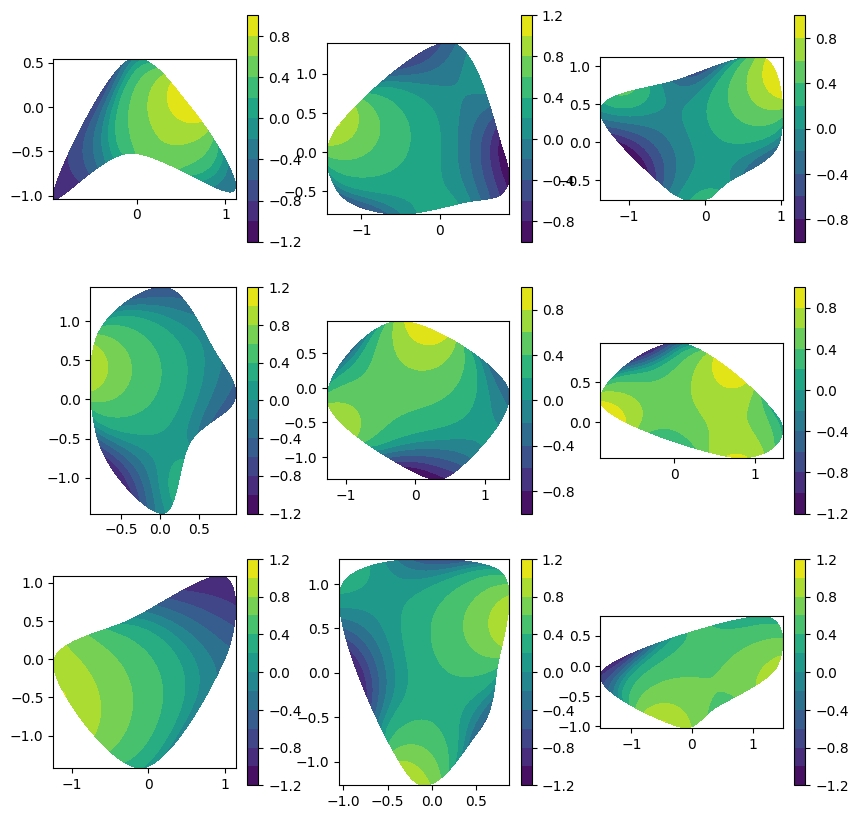

In [444]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    elements = np.array(dataset[i+9]['elements'])
    nodes = np.array(dataset[i+9]['nodes'])
    l = np.array(dataset[i+9]['l'])

    # Create a Triangulation object
    triangulation = tri.Triangulation(nodes[:, 0], nodes[:, 1], elements)

    # Plotting
    plt.tricontourf(triangulation, l[:,0],10)
    plt.colorbar()
    plt.gca().set_aspect('equal', adjustable='box')

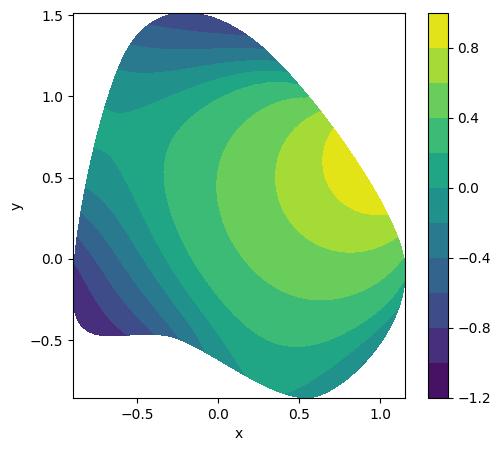

In [440]:
solution = dataset[2]
PlotFEMsoluttionDict(solution)

Iteration 1; err = 0.02700666163094086
Iteration 2; err = 0.011040715339435021
Iteration 3; err = 0.0031492805199655424
Iteration 4; err = 0.0006046213746053647
Iteration 5; err = 7.824732166036742e-05
Iteration 6; err = 2.6529835217363227e-05
Iteration 7; err = 4.577933074487054e-06
Iteration 8; err = 1.1751486244661872e-06
Iteration 9; err = 2.9111508264641873e-07
Iteration 10; err = 4.364217155540716e-08
Iteration 11; err = 1.6227922444304482e-08
Iteration 12; err = 2.040980627512531e-09


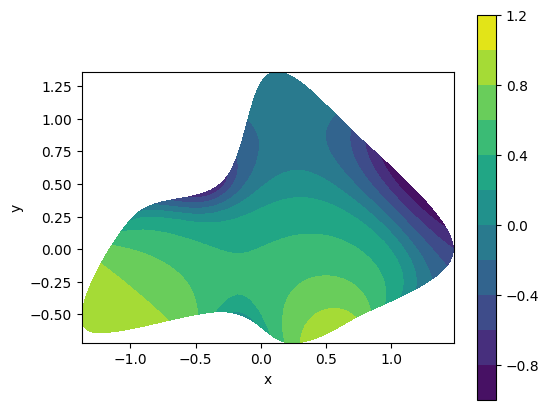

In [238]:
# A11 = np.array([[1,0],[0,1]])
# A12 = np.array([[0,0],[0,0]])
# A22 = np.array([[1,0.5],[0.5,1]])
# A = np.concatenate([
#     np.concatenate([A11,A12],axis=1),
#     np.concatenate([A12,A22],axis=1)
# ],axis=0)
# r=2


A = lambda u: np.concatenate([
    np.concatenate([[[10*np.max([u.mean(),0])**2+0.5]],[[0]]],axis=1),
    np.concatenate([[[0]],[[10*np.max([u.mean(),0])**2+0.5]]],axis=1)
],axis=0)
A_lin = A(np.array([0]))
r = 1

# Define Dirichlet BC
# n_order = 3
# p = np.random.randn(2,n_order,r)
# BCfunc_unscaled = lambda alpha: np.array([[p[0,j,i]*np.cos((j+1)*alpha) + p[1,j,i]*np.sin((j+1)*alpha) for i in range(r)] for j in range(n_order)]).T.sum(axis=-1)
# alpha = np.linspace(0,2*np.pi,100)
# vals = BCfunc_unscaled(alpha)
# vals_max = np.max(vals)
# vals_min = np.min(vals)
# BCfunc = lambda alpha: (BCfunc_unscaled(alpha)-vals_min)/(vals_max-vals_min)*2-1

internalNodes = np.setdiff1d(np.arange(nodes.shape[0]), boundaryNodes)
l_lin = SolveFEM(nodes, elements, boundaryNodes, BCfunc, internalNodes, r, A_lin, A_nl=False, l=None)
l,iters = SolveFEM_itt(nodes, elements, boundaryNodes, BCfunc, internalNodes, r, A, tol=1e-8,show_err=True, max_iter=20)
triangulation = PlotFEMsolution(nodes, elements,l)

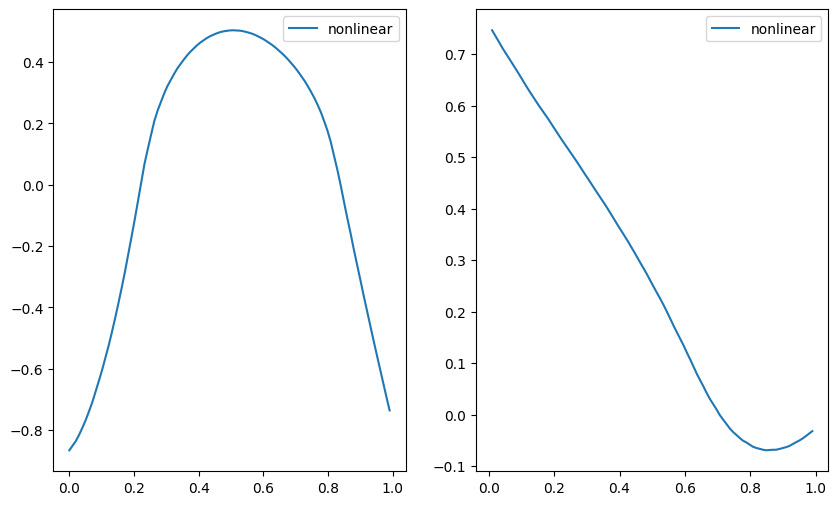

In [347]:
interp = LinearNDInterpolator(nodes, l)
# interp_lin = LinearNDInterpolator(nodes, l_lin)
scaler = np.linspace(0,1,100).reshape(-1,1)
n = points.shape[0]//2
n_2 = points.shape[0]//4
points_line1 = (points[0:1,:]*(1-scaler)+points[n:n+1,:]*scaler)
points_line2 = (points[n_2:n_2+1,:]*(1-scaler)+points[n_2+n:n_2+n+1,:]*scaler)
z1 = interp(points_line1)
# z1_lin = interp_lin(points_line1)
z2 = interp(points_line2)
# z2_lin = interp_lin(points_line2)
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(scaler,z1[:,:],label='nonlinear')
# plt.plot(scaler,z1_lin[:,:],label='linear')
plt.legend()
plt.subplot(1,2,2)
plt.plot(scaler,z2[:,:],label='nonlinear')
# plt.plot(scaler,z2_lin[:,:],label='linear')
plt.legend()

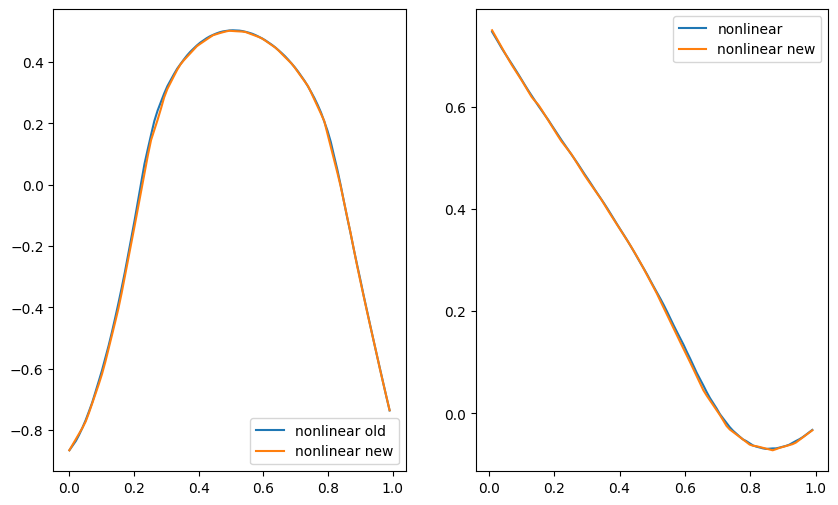

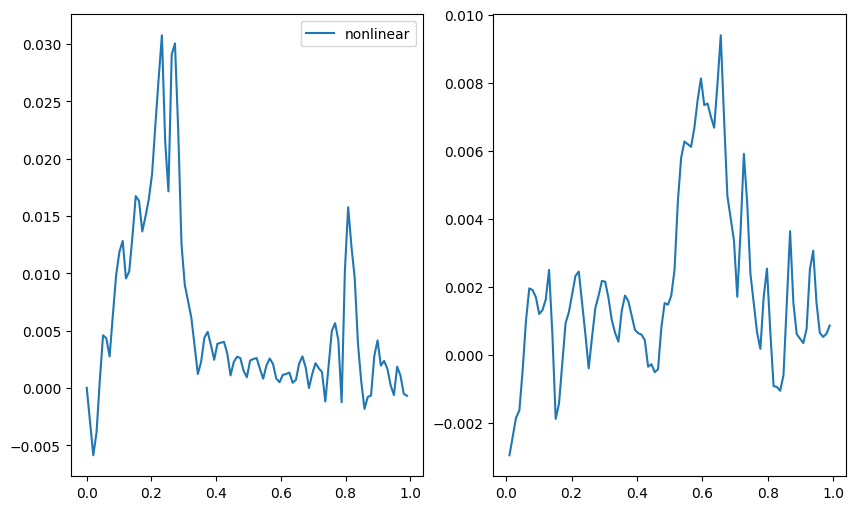

In [350]:
interp = LinearNDInterpolator(nodes, l)
# interp_lin = LinearNDInterpolator(nodes, l_lin)
z1_new = interp(points_line1)
# z1_lin_new = interp_lin(points_line1)
z2_new = interp(points_line2)
# z2_lin_new = interp_lin(points_line2)
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(scaler,z1[:,:],label='nonlinear old')
# plt.plot(scaler,z1_lin[:,:],label='linear old')
plt.plot(scaler,z1_new[:,:],label='nonlinear new')
# plt.plot(scaler,z1_lin_new[:,:],label='linear new')
plt.legend()
plt.subplot(1,2,2)
plt.plot(scaler,z2[:,:],label='nonlinear')
# plt.plot(scaler,z2_lin[:,:],label='linear')
plt.plot(scaler,z2_new[:,:],label='nonlinear new')
# plt.plot(scaler,z2_lin_new[:,:],label='linear new')
plt.legend()

plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.plot(scaler,z1[:,:]-z1_new[:,:],label='nonlinear')
# plt.plot(scaler,z1_lin[:,:]-z1_lin_new[:,:],label='linear')
plt.legend()
plt.subplot(1,2,2)
plt.plot(scaler,z2[:,:]-z2_new[:,:],label='nonlinear')
# plt.plot(scaler,z2_lin[:,:]-z2_lin_new[:,:],label='linear')

In [451]:
N = 'aabdedc'
K = 'bda'

N[0] in K

True

In [453]:
np.where(np.array(list(K))==N[0])[0][0]

2

In [461]:
K_res = list(K)
K_res

['b', 'd', 'a']

In [467]:
a = np.array([0,1,1,2,2,3,4,5])
a[a==1]

array([1, 1])